# Cuisine-recipe analysis and classification

### Author: Anna-Lena Wölwer

### Structure
* [Preparation](#bullet1)
* [Understanding and cleaning the data](#bullet2)
* [Exploratory data analysis](#bullet3)
* [Similarities of recipes and cuisines](#bullet4)
* [Classification of recipe cuisines](#bullet5)

# Preparation  <a class="anchor" id="bullet1"></a>


## Dependencies & Settings

In [1]:
# Load Libraries
library(data.table)
library(ggplot2)
library(reshape2)
library(lsa)
library(stringr)
library(Rtsne)
library(splitstackshape)
library(tidyverse)
library(randomForest)
library(rpart)
library(xgboost)
library(class)
library(naivebayes)
library(tidytext)

# Change plot settings
options(repr.plot.width = 14, repr.plot.height = 12)


Attache Paket: 'reshape2'


Die folgenden Objekte sind maskiert von 'package:data.table':

    dcast, melt


Lade nötiges Paket: SnowballC

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.7     ✔ purrr   0.3.4
✔ tidyr   1.2.0     ✔ dplyr   1.0.9
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()
randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attache Paket: 'randomForest'


Das folgende Objekt ist maskiert 'package:dplyr':

    combine


Das folgende Objekt ist maskiert 'package:ggplot2':

    ma

## Import data

In [2]:
recipes     <- setDT(read.csv(file = paste0("~/Cuisines-Classification-by-Ingredients/", "data/", "recipes.csv")))
ingredients <- setDT(read.csv(file = paste0("~/Cuisines-Classification-by-Ingredients/", "data/", "ingredients.csv")))

# Note: No meta-data available

## Data structure

In [3]:
# str(ingredients)
head(ingredients)

ID_recipe ingredients    
1 10259     romaine lettuce
2 10259     black olives   
3 10259     grape tomatoes 
4 10259     garlic         
5 10259     pepper         
6 10259     purple onion

In [4]:
# str(recipes)
head(recipes)

ID    cuisine    
1 10259 greek      
2 25693 southern_us
3 20130 filipino   
4 22213 indian     
5 13162 indian     
6  6602 jamaican

In [5]:
# Check for NAs
anyNA(recipes)
anyNA(recipes)

[1] FALSE

[1] FALSE

In [6]:
# Do both datasets contain same IDs?
unique(c( all(unique(ingredients$ID_recipe) %in% unique(recipes$ID)),
          all(unique(recipes$ID_recipe)     %in% unique(ingredients$ID)) ))

[1] TRUE

# Understanding and cleaning the data  <a class="anchor" id="bullet2"></a>

## Dataset 'recipe'

In [7]:
# Are IDs unique?
nrow(recipes) == recipes[, length(unique(ID))]

[1] TRUE

In [8]:
# Number of different cuisines
recipes[, length(unique(cuisine))]
cuisine_uni <- recipes[, unique(cuisine)]

[1] 20

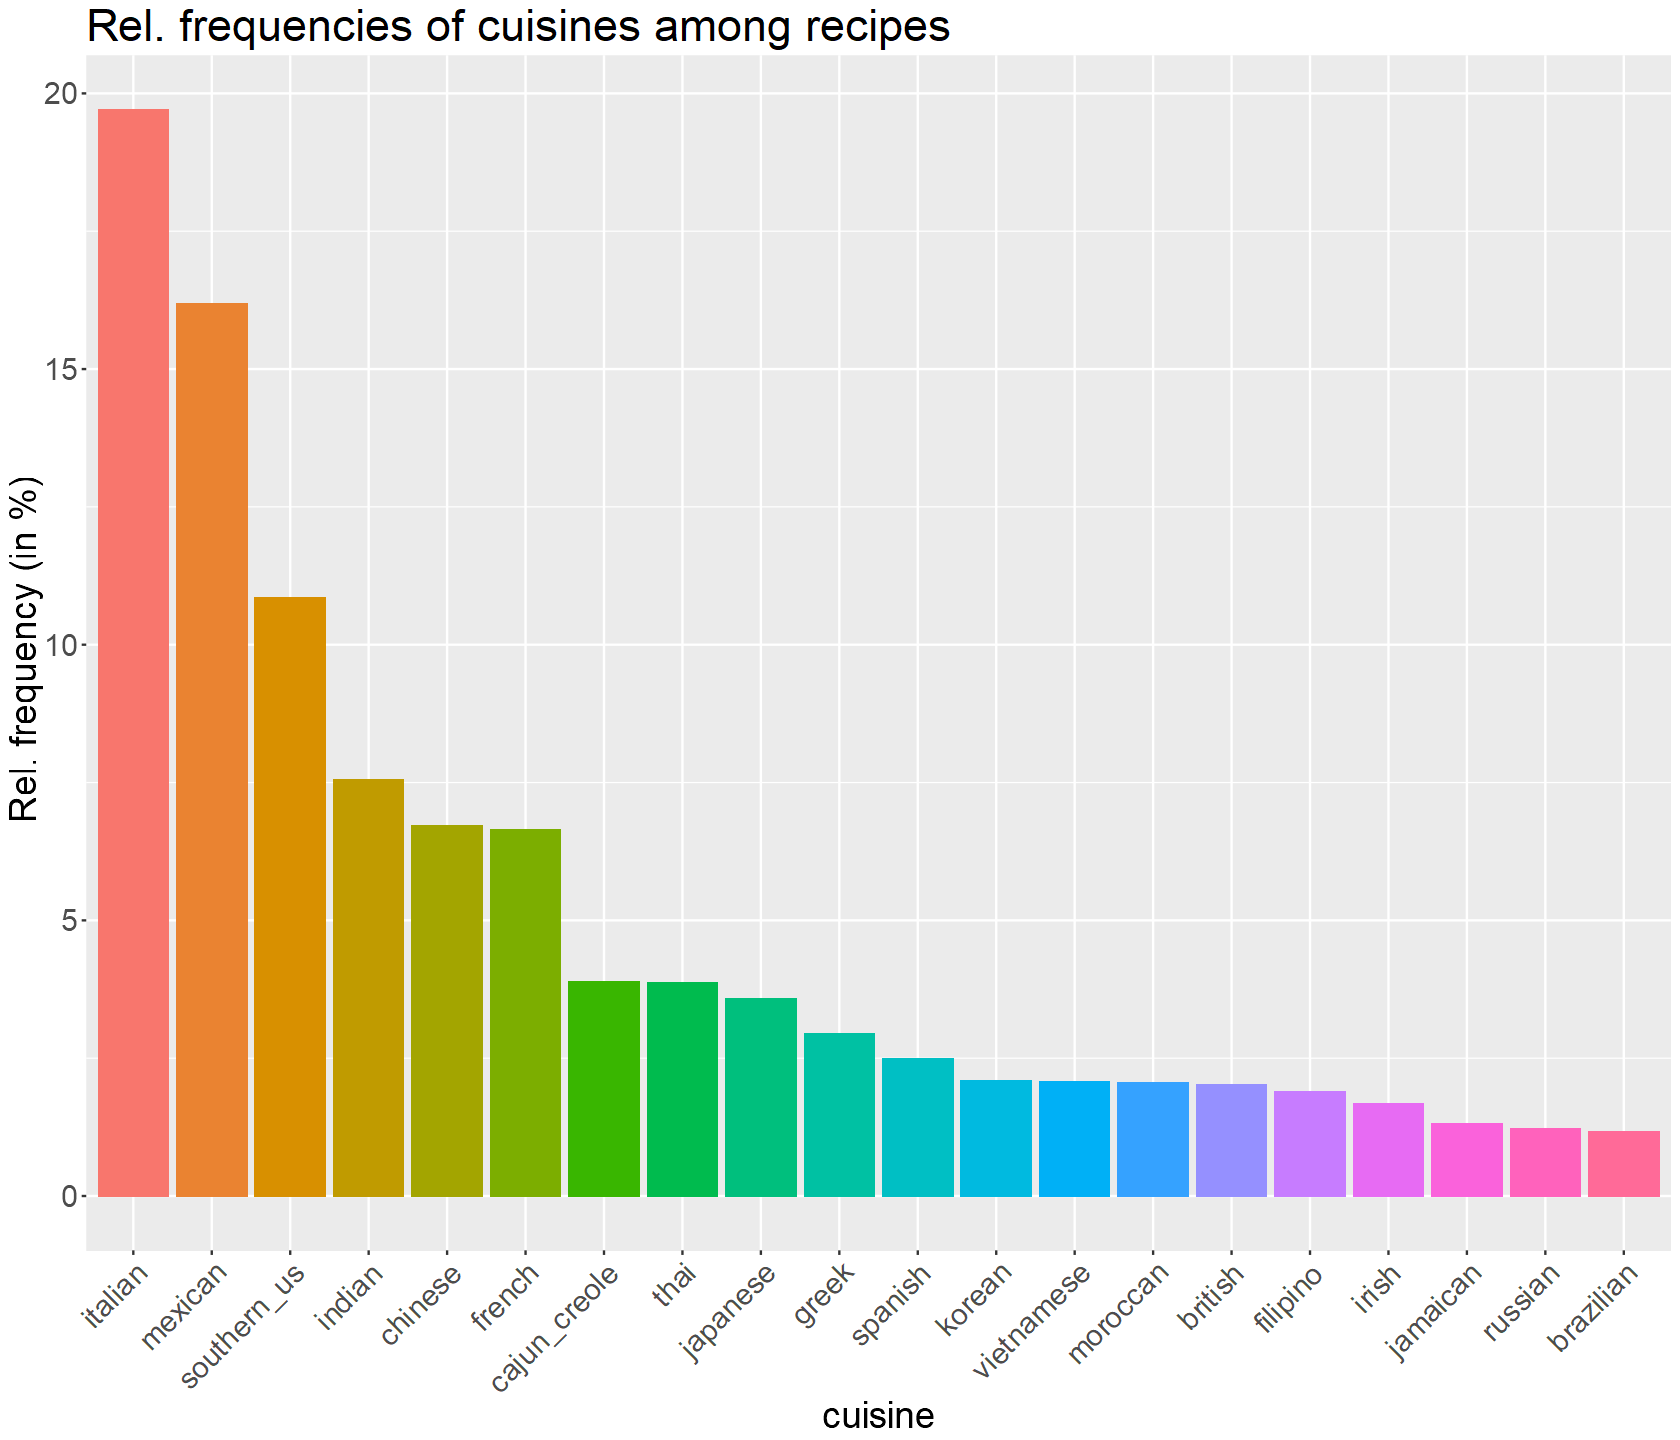

In [9]:
# Number of recipes per cuisine
cuis_rec_tab         <- data.table(recipes[, sort(table(cuisine), decreasing = TRUE)]) 
cuis_rec_tab$cuisine <- factor(cuis_rec_tab$cuisine, levels = cuis_rec_tab$cuisine)


plot_tmp <- ggplot(cuis_rec_tab,
                   aes(x = cuisine, y = N/cuis_rec_tab[, sum(N)] * 100, fill = cuisine)) +
              geom_bar(stat = "identity") +
              theme(legend.position = 'none',
                    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) +
              labs(title = "Rel. frequencies of cuisines among recipes") +
              xlab("cuisine") +
              ylab("Rel. frequency (in %)")
print(plot_tmp, vp = grid::viewport(gp = grid::gpar(cex = 2)))

In [10]:
# Relative frequencies: Quantiles and mean
print(recipes[, round(c(quantile(prop.table(table(cuisine)) * 100), 
                  "Mean" = mean(prop.table(table(cuisine))) * 100))])

  0%  25%  50%  75% 100% Mean 
   1    2    3    7   20    5 


## Merge datasets 'recipes' and 'ingredients' to 'd_rec' 

In [11]:
colnames(ingredients)[colnames(ingredients) == "ID_recipe"] <- "ID"
d_rec <- merge.data.table(recipes, 
                          ingredients, 
                          by = "ID", 
                          all = TRUE, 
                          sort = FALSE)
head(d_rec)
rm(ingredients)

cat(paste0("Dataset 'd_rec' contains ", 
           nrow(d_rec),
           " rows with ",
           d_rec[, length(unique(ID))],
           " recipes,\nwhich contain ",
           d_rec[, length(unique(ingredients))],
           " different ingredients"))

ID    cuisine ingredients    
1 10259 greek   romaine lettuce
2 10259 greek   black olives   
3 10259 greek   grape tomatoes 
4 10259 greek   garlic         
5 10259 greek   pepper         
6 10259 greek   purple onion

Dataset 'd_rec' contains 428275 rows with 39774 recipes,
which contain 6714 different ingredients

## Check the number of ingredients per recipe 

In [12]:
# Quantiles
d_rec[, quantile(table(ID))]

# Recipes with one ingredient
ID_tmp <- d_rec[, names(table(ID)[table(ID) == 1])]
d_rec[ID %in% ID_tmp, ]

  0%  25%  50%  75% 100% 
   1    8   10   13   65 

ID    cuisine     ingredients             
1   4734 japanese    sushi rice              
2   7833 vietnamese  dried rice noodles      
3  36818 indian      plain low-fat yogurt    
4  19772 indian      unsalted butter         
5  16116 japanese    udon                    
6  29738 thai        sticky rice             
7  41124 indian      butter                  
8  32631 mexican     corn tortillas          
9  29570 thai        grained                 
10 29849 southern_us lemonade concentrate    
11 39186 thai        jasmine rice            
12 14335 indian      unsalted butter         
13 39221 italian     cherry tomatoes         
14 41135 french      butter                  
15 36874 indian      cumin seed              
16 35028 french      haricots verts          
17 18593 mexican     vegetable oil           
18  7460 spanish     spanish chorizo         
19 32772 spanish     sweetened condensed milk
20 12805 japanese    water                   
21 10816 greek       phyllo                  
22 27192 indian      unsalted butter

In [13]:
# Recipes with more than 40 ingredients
ID_tmp <- d_rec[, names(table(ID)[table(ID) > 40])]
d_rec[ID == ID_tmp[2], unique(cuisine)]
d_rec[ID == ID_tmp[2], as.vector(ingredients)]

[1] "italian"

[1] "fettucine"                              
 [2] "fresh marjoram"                         
 [3] "minced garlic"                          
 [4] "olive oil"                              
 [5] "garlic powder"                          
 [6] "large eggs"                             
 [7] "Alfredo sauce"                          
 [8] "vegetable oil"                          
 [9] "cajun seasoning"                        
[10] "shredded romano cheese"                 
[11] "basil dried leaves"                     
[12] "salt"                                   
[13] "cayenne pepper"                         
[14] "scallions"                              
[15] "red bell pepper"                        
[16] "boneless skinless chicken breast halves"
[17] "soba"                                   
[18] "pasta sauce"                            
[19] "kosher salt"                            
[20] "milk"                                   
[21] "fresh ginger"                           
[22] "ground black pepper"                    
[23] "flour"                                  
[24] "cooked chicken"                         
[25] "coarse salt"                            
[26] "lemon"                                  
[27] "diced tomatoes"                         
[28] "garlic"                                 
[29] "rice vinegar"                           
[30] "Neufchâtel"                             
[31] "garlic cloves"                          
[32] "dried parsley"                          
[33] "frozen artichoke hearts"                
[34] "penne"                                  
[35] "pepper"                                 
[36] "sweet onion"                            
[37] "part-skim mozzarella cheese"            
[38] "parmigiano reggiano cheese"             
[39] "basil leaves"                           
[40] "onion powder"                           
[41] "red wine vinegar"                       
[42] "red pepper flakes"                      
[43] "orzo"                                   
[44] "crushed red pepper"                     
[45] "all-purpose flour"                      
[46] "freshly ground pepper"                  
[47] "sliced mushrooms"                       
[48] "panko breadcrumbs"                      
[49] "plum tomatoes"                          
[50] "fresh basil"                            
[51] "fresh leav spinach"                     
[52] "water"                                  
[53] "sun-dried tomatoes"                     
[54] "ground pepper"                          
[55] "grated parmesan cheese"                 
[56] "boneless skinless chicken breasts"      
[57] "chicken cutlets"                        
[58] "butter"                                 
[59] "multi-grain penne pasta"                
[60] "extra-virgin olive oil"                 
[61] "cilantro leaves"                        
[62] "green pepper"                           
[63] "shredded mozzarella cheese"             
[64] "fresh parsley"                          
[65] "spaghetti"

## Check the ingredients

In [14]:
# Length of ingredient names
print(d_rec[, round(c(quantile(nchar(ingredients)), 
                "Mean" = mean(nchar(ingredients))), digits = 2)])

   0%   25%   50%   75%  100%  Mean 
 2.00  7.00 12.00 15.00 71.00 11.72 


In [15]:
# Ingredients with name length <= 3
d_rec[nchar(ingredients) <= 3, sort(table(ingredients), decreasing = TRUE)]

ingredients
 oil  ham  ice  fat  rum  rib  cod  msg  jam  rub  pig  dal  gin  min  ale  soy 
1970  222  111   92   77   59   36   29   27   17   15   14   14   14   13   12 
 red  ahi  rye  mie  roe  any  eel   mi  tvp   v8  hen  kha  lox  poi  uni  val 
  10    5    4    3    3    2    2    2    2    2    1    1    1    1    1    1 

In [16]:
# Ingredients with name length >= 40
d_rec[nchar(ingredients) >= 40, sort(table(ingredients), decreasing = TRUE)][1:10]

ingredients
                   frozen chopped spinach, thawed and squeezed dry 
                                                                21 
                          I Can't Believe It's Not Butter!® Spread 
                                                                18 
                        Campbell's Condensed Cream of Chicken Soup 
                                                                10 
                     Pillsbury™ Refrigerated Crescent Dinner Rolls 
                                                                10 
                          Campbell's Condensed Cheddar Cheese Soup 
                                                                 6 
bertolli vineyard premium collect marinara with burgundi wine sauc 
                                                                 5 
                          fat skimmed reduced sodium chicken broth 
                                                                 5 
                   KRAFT Mexican Sty

In [17]:
# Number of recipes which contain ingredients with name length >= 30
d_rec[nchar(ingredients) >= 30, length(table(unique(ID)))]

[1] 3680

## Check the ingredient-words

In [18]:
# Split ingredients in ingredient-words 
ingr_words_uni <- d_rec[, unique(ingredients)]
ingr_words_uni <- lapply(ingr_words_uni, function (x) { strsplit(x, " ")[[1]] })
ingr_words_uni <- unique(unlist(ingr_words_uni))

In [19]:
# Length of single ingredients-words
print(quantile(nchar(ingr_words_uni)))

  0%  25%  50%  75% 100% 
   0    5    6    8   19 


In [20]:
# Ingredient-words with small length
ingr_words_uni[nchar(ingr_words_uni) <= 2][1:40]

[1] "lo" "1%" "el" "2%" "in" "of" "El" "de" "("  ""   "&"  "4"  "or" "I"  "no"
[16] "St" "ti" "ox" "Mo" "on" "'N" "ic" "A"  "yu" "i"  "'n" "du" "7"  "Up" "-" 
[31] "au" "mo" "O"  "mi" "la" "8"  "up" "di" "a"  "OF"

In [21]:
# Ingredient-words with large length
table(ingr_words_uni[nchar(ingr_words_uni) >= 16])


   butter-margarine    chicken-flavored  chocolate-hazelnut    chocolatecovered 
                  1                   1                   1                   1 
   hickory-flavored parmigiana-reggiano parmigiano-reggiano    vegetable-filled 
                  1                   1                   1                   1 

## Clean ingredient names

In [22]:
# Create 1:1 map of original and adjusted ingredients names
d_rec_old_new <- data.table(ingredients = d_rec[, unique(ingredients)],
                            ingr_new    = d_rec[, unique(ingredients)])

# Convert to ASCI
d_rec_old_new[, ingr_new := iconv(ingr_new, from = 'UTF-8', to = 'ASCII//TRANSLIT')]

# Remove numbers
d_rec_old_new[, ingr_new := gsub('[[:digit:]]+', '', ingr_new)]

# Remove special characters
d_rec_old_new[, ingr_new := gsub('[[:punct:]]+', '', ingr_new)]

# Transfer all letters to lower case
d_rec_old_new[, ingr_new := tolower(ingr_new)]

# Remove certain non-ingredient words 
words_to_rem <- c(" and ", " or ", " of ", "fresh", "sea",
                  "large", "unsalted", "extra", "virgin",
                  "cloves", " oz ", " cn ")
for ( i in words_to_rem ) {
  d_rec_old_new[, ingr_new := gsub(i, '', ingr_new)]
}

# Remove double empty space
d_rec_old_new[, ingr_new := gsub('  ', ' ', ingr_new)]
d_rec_old_new[, ingr_new := gsub('  ', ' ', ingr_new)]
d_rec_old_new[, ingr_new := gsub('  ', ' ', ingr_new)]

# Remove empty space at ingredient begin
d_rec_old_new[, ingr_new := stringr::str_trim(ingr_new, "left")]

# Remove empty space at ingredient end
d_rec_old_new[, ingr_new := stringr::str_trim(ingr_new, "right")]

# Replace blank character " " by "_"
d_rec_old_new[, ingr_new := gsub(' ', '_', ingr_new)]

# Merge new ingredient names to 'd_rec'
d_rec <- merge.data.table(d_rec, 
                          d_rec_old_new, 
                          all = TRUE, 
                          sort = FALSE, 
                          by = "ingredients")

# Delete rows with empty ingredient
d_rec <- d_rec[!ingr_new == "",]
rm(d_rec_old_new)

cat(paste0("Number of unique ingredients in original data = ",
           d_rec[, length(unique(ingredients))],
           "\nNumber of unique ingredients in adjusted data = ",
           d_rec[, length(unique(ingr_new))]
))

d_rec[, ingredients := NULL]
d_rec$cuisine  <- as.factor(d_rec$cuisine)
d_rec$ingr_new <- as.factor(d_rec$ingr_new)

Number of unique ingredients in original data = 6713
Number of unique ingredients in adjusted data = 6564

In [23]:
# Delete duplicate data rows (e.g. rows with two ingredients equal to "salt")
dim(d_rec)
d_rec <- unique(d_rec)
dim(d_rec)

[1] 428274      3

[1] 427647      3

# Exploratory data analysis <a class="anchor" id="bullet3"></a>

## Number of ingredients per cuisine

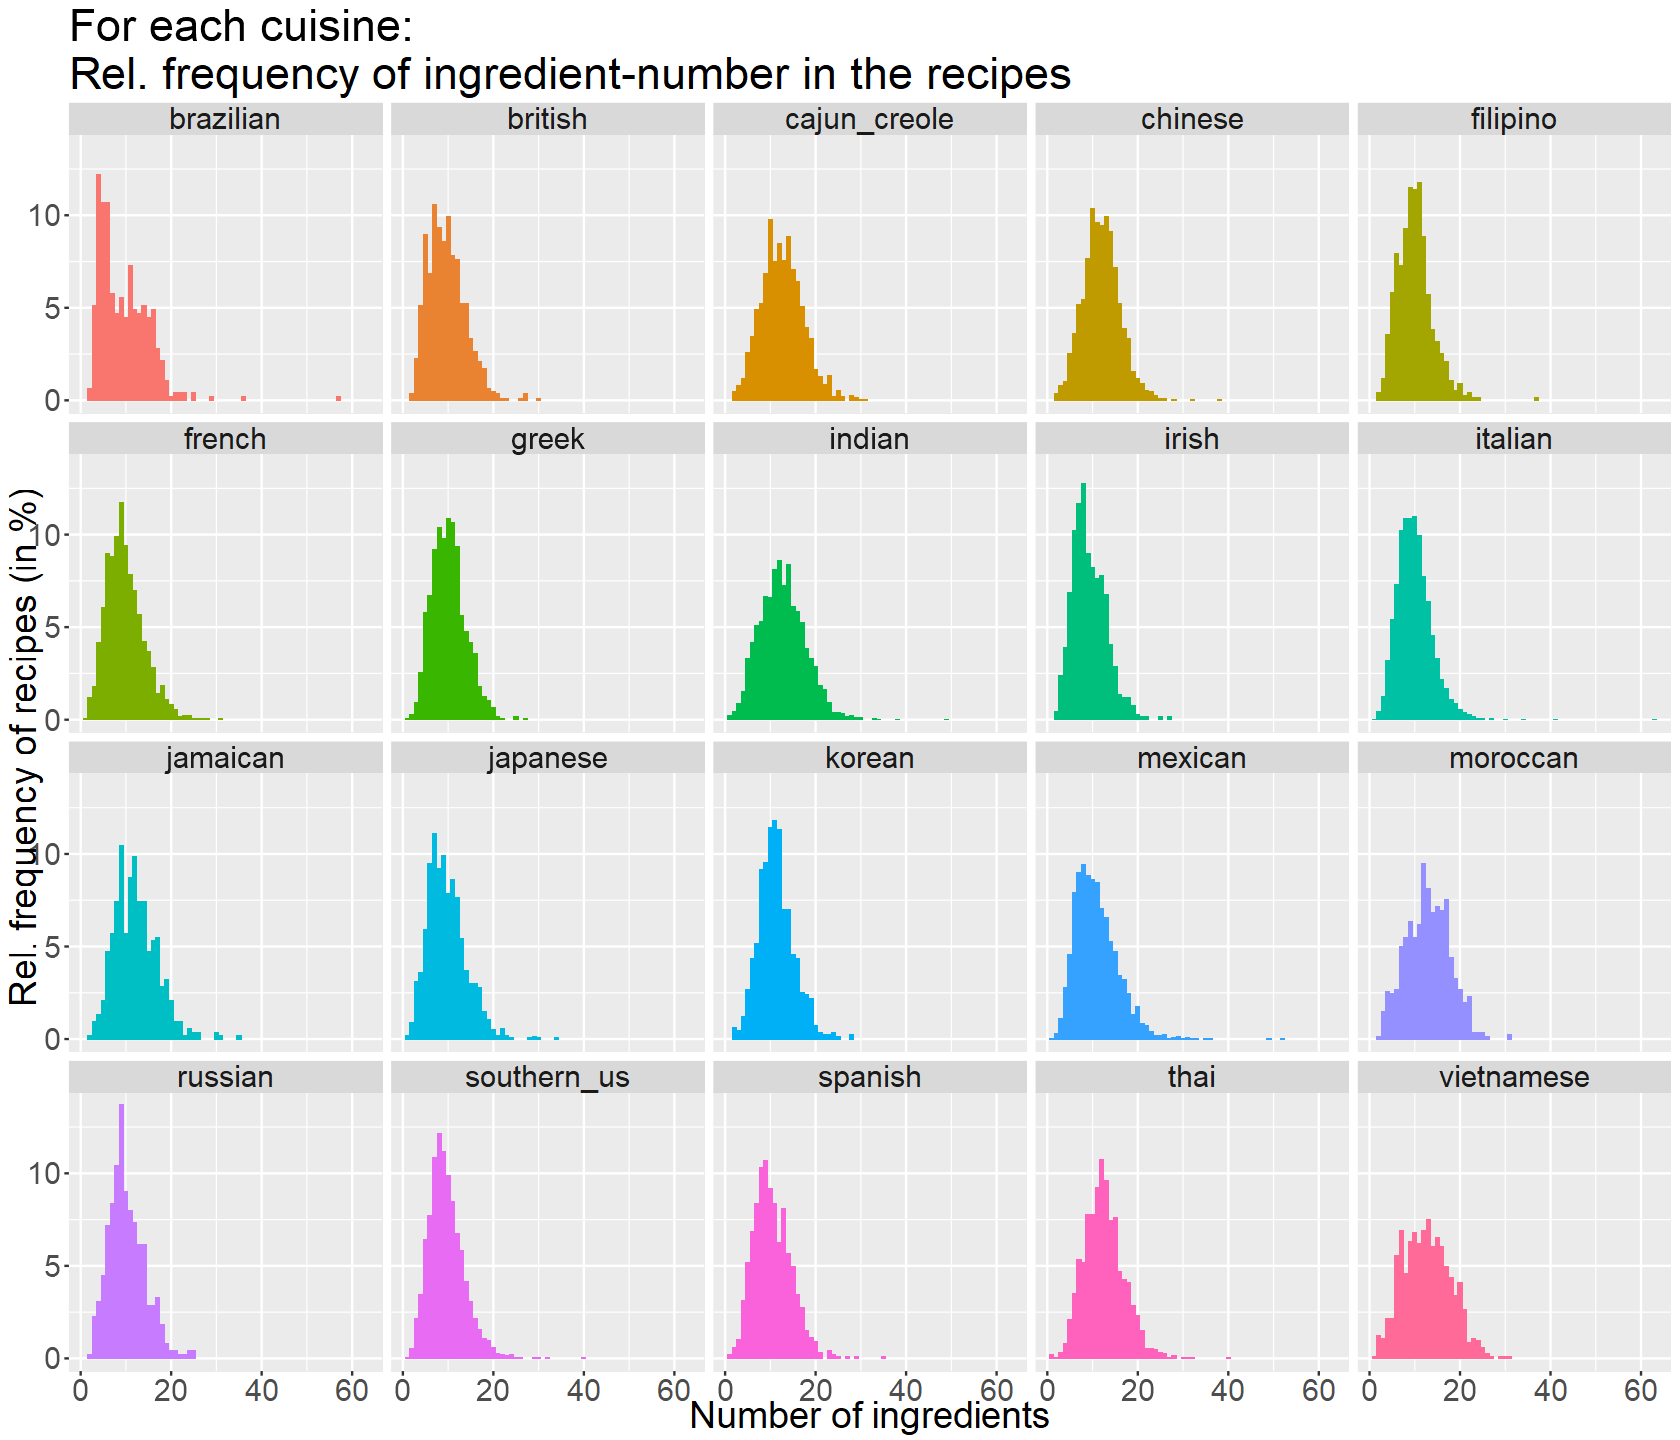

In [24]:
ID_tab <- data.table(d_rec[, sort(table(ID), decreasing = TRUE)]) 
ID_tab[, ID := as.numeric(ID)]
ID_tab <- merge.data.table(ID_tab, 
                           recipes,  
                           sort = FALSE, 
                           by = "ID")
rm(recipes)

plot_tmp <- ggplot(ID_tab,
                   aes(x = N, group = cuisine, fill = cuisine)) +
              geom_bar(aes(y = (..prop..*100))) +
              facet_wrap(~cuisine) +
              theme(legend.position = "none") +
              labs(title = "For each cuisine:\nRel. frequency of ingredient-number in the recipes") +
              xlab("Number of ingredients") +
              ylab("Rel. frequency of recipes (in %)")
print(plot_tmp, vp = grid::viewport(gp = grid::gpar(cex = 2)))

rm(ID_tab)

## Frequency of ingredients

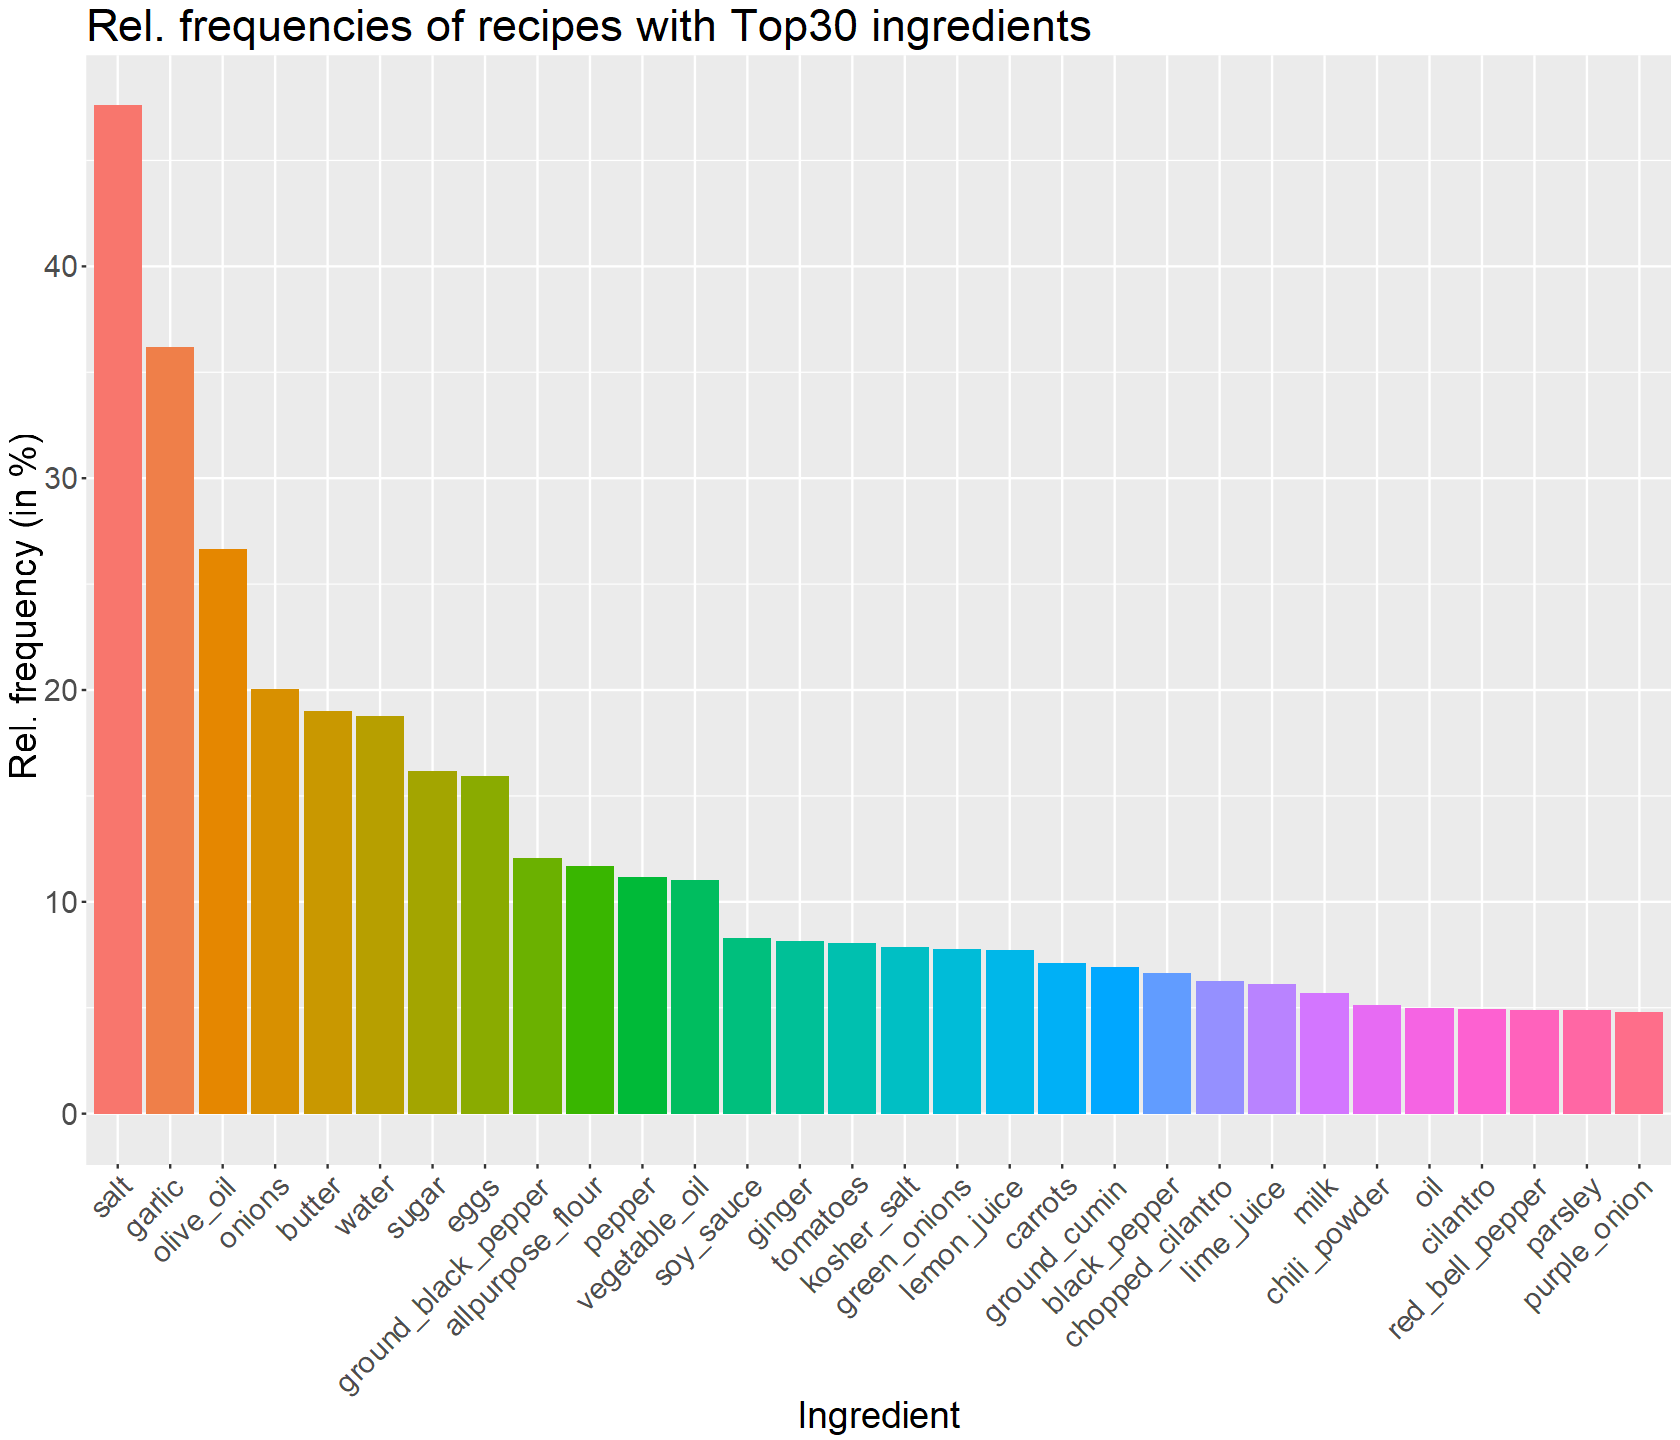

In [25]:
ingr_tab          <- data.table(d_rec[, sort(table(ingr_new), decreasing = TRUE)]) 
ingr_tab$ingr_new <- factor(ingr_tab$ingr_new, levels = ingr_tab$ingr_new)

plot_tmp <- ggplot(ingr_tab[1:30],
                   aes(x = ingr_new, y = N/d_rec[, length(unique(ID))] * 100, group = ingr_new, fill = ingr_new)) +
              geom_bar(stat = "identity") +
              theme(legend.position = 'none',
                    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) +
              labs(title = "Rel. frequencies of recipes with Top30 ingredients") +
              xlab("Ingredient") +
              ylab("Rel. frequency (in %)")
            print(plot_tmp, vp = grid::viewport(gp = grid::gpar(cex = 2)))

In [26]:
# Number of recipes per ingredient: Quantiles and mean
print(d_rec[, round(c(quantile(table(ingr_new)), 
                "Mean" =  mean(table(ingr_new))), digits = 0)])

   0%   25%   50%   75%  100%  Mean 
    1     1     4    19 18927    65 


## Most frequent ingredients per cuisine

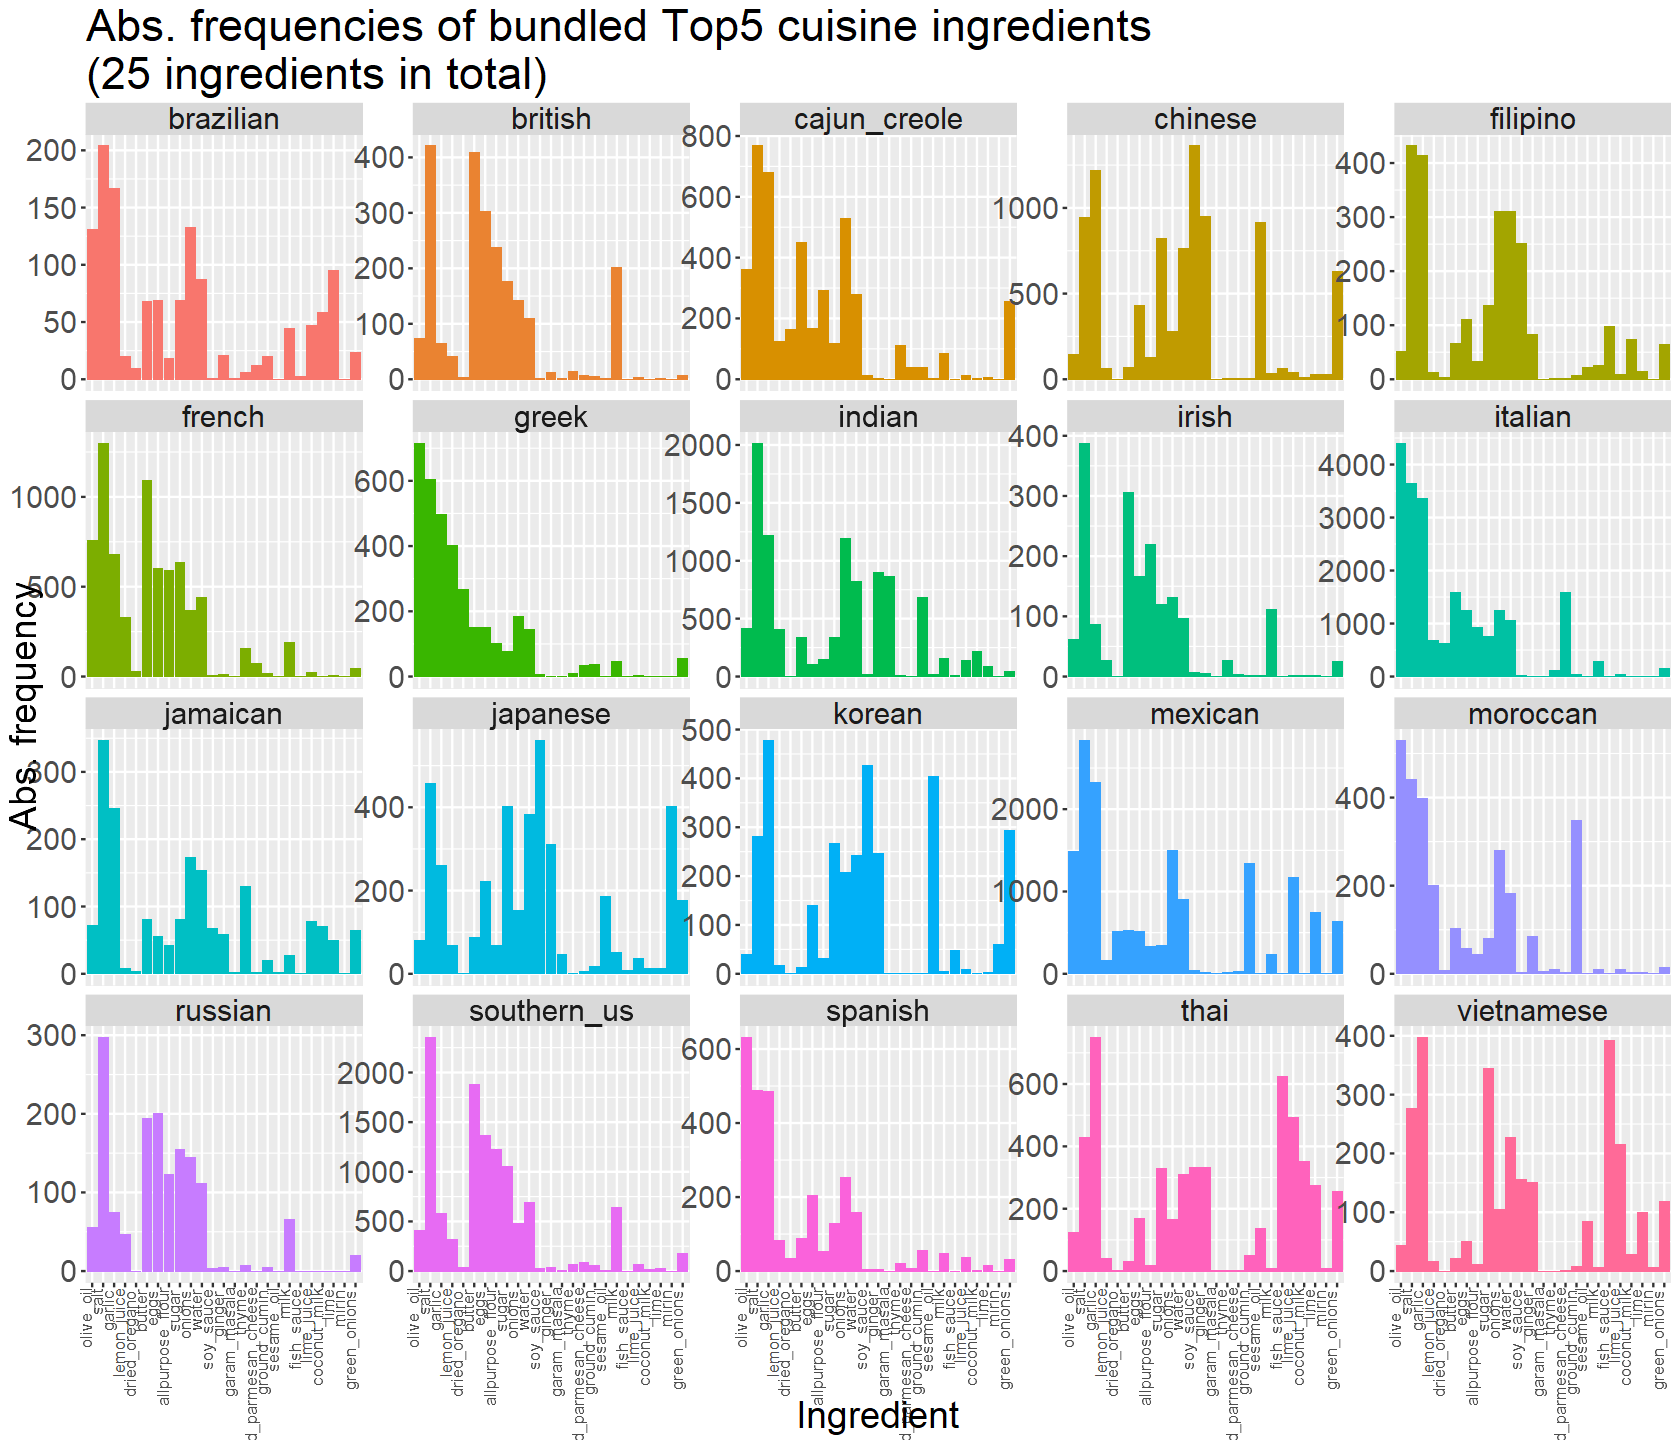

In [27]:
nr_tmp <- 5
ingr_Top_n_cuis <- sapply(cuisine_uni,
                          function (x) {
                            names(d_rec[cuisine == x, sort(table(ingr_new), decreasing = TRUE)][1:nr_tmp])
                          })
ingr_Top_n_cuis_list  <- unique(as.vector(ingr_Top_n_cuis))
d_rec_ingr_Top_n_cuis <- d_rec[ingr_new %in% ingr_Top_n_cuis_list, table(ingr_new, cuisine)]
d_rec_ingr_Top_n_cuis <- d_rec_ingr_Top_n_cuis[ingr_Top_n_cuis_list,]
d_rec_ingr_Top_n_cuis <- setDT(reshape2::melt(d_rec_ingr_Top_n_cuis))
d_rec_ingr_Top_n_cuis <- droplevels(d_rec_ingr_Top_n_cuis)

plot_tmp <- ggplot(d_rec_ingr_Top_n_cuis,
                   aes(x = ingr_new, y = value, group = cuisine, fill = cuisine)) +
              geom_bar(stat = "identity") +
              facet_wrap(~ cuisine, scales = "free_y") +
              theme(legend.position = 'none',
                    axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0, size = 5)) +
              labs(title = paste0("Abs. frequencies of bundled Top", nr_tmp," cuisine ingredients\n",
                                  "(", length(ingr_Top_n_cuis_list), " ingredients in total)")) +
              xlab(paste0("Ingredient")) +
              ylab("Abs. frequency") 
print(plot_tmp, vp = grid::viewport(gp = grid::gpar(cex = 2)))

In [28]:
print(levels(d_rec_ingr_Top_n_cuis$ingr_new))
rm(d_rec_ingr_Top_n_cuis)

 [1] "olive_oil"              "salt"                   "garlic"                
 [4] "lemon_juice"            "dried_oregano"          "butter"                
 [7] "eggs"                   "allpurpose_flour"       "sugar"                 
[10] "onions"                 "water"                  "soy_sauce"             
[13] "ginger"                 "garam_masala"           "thyme"                 
[16] "grated_parmesan_cheese" "ground_cumin"           "sesame_oil"            
[19] "milk"                   "fish_sauce"             "lime_juice"            
[22] "coconut_milk"           "lime"                   "mirin"                 
[25] "green_onions"          


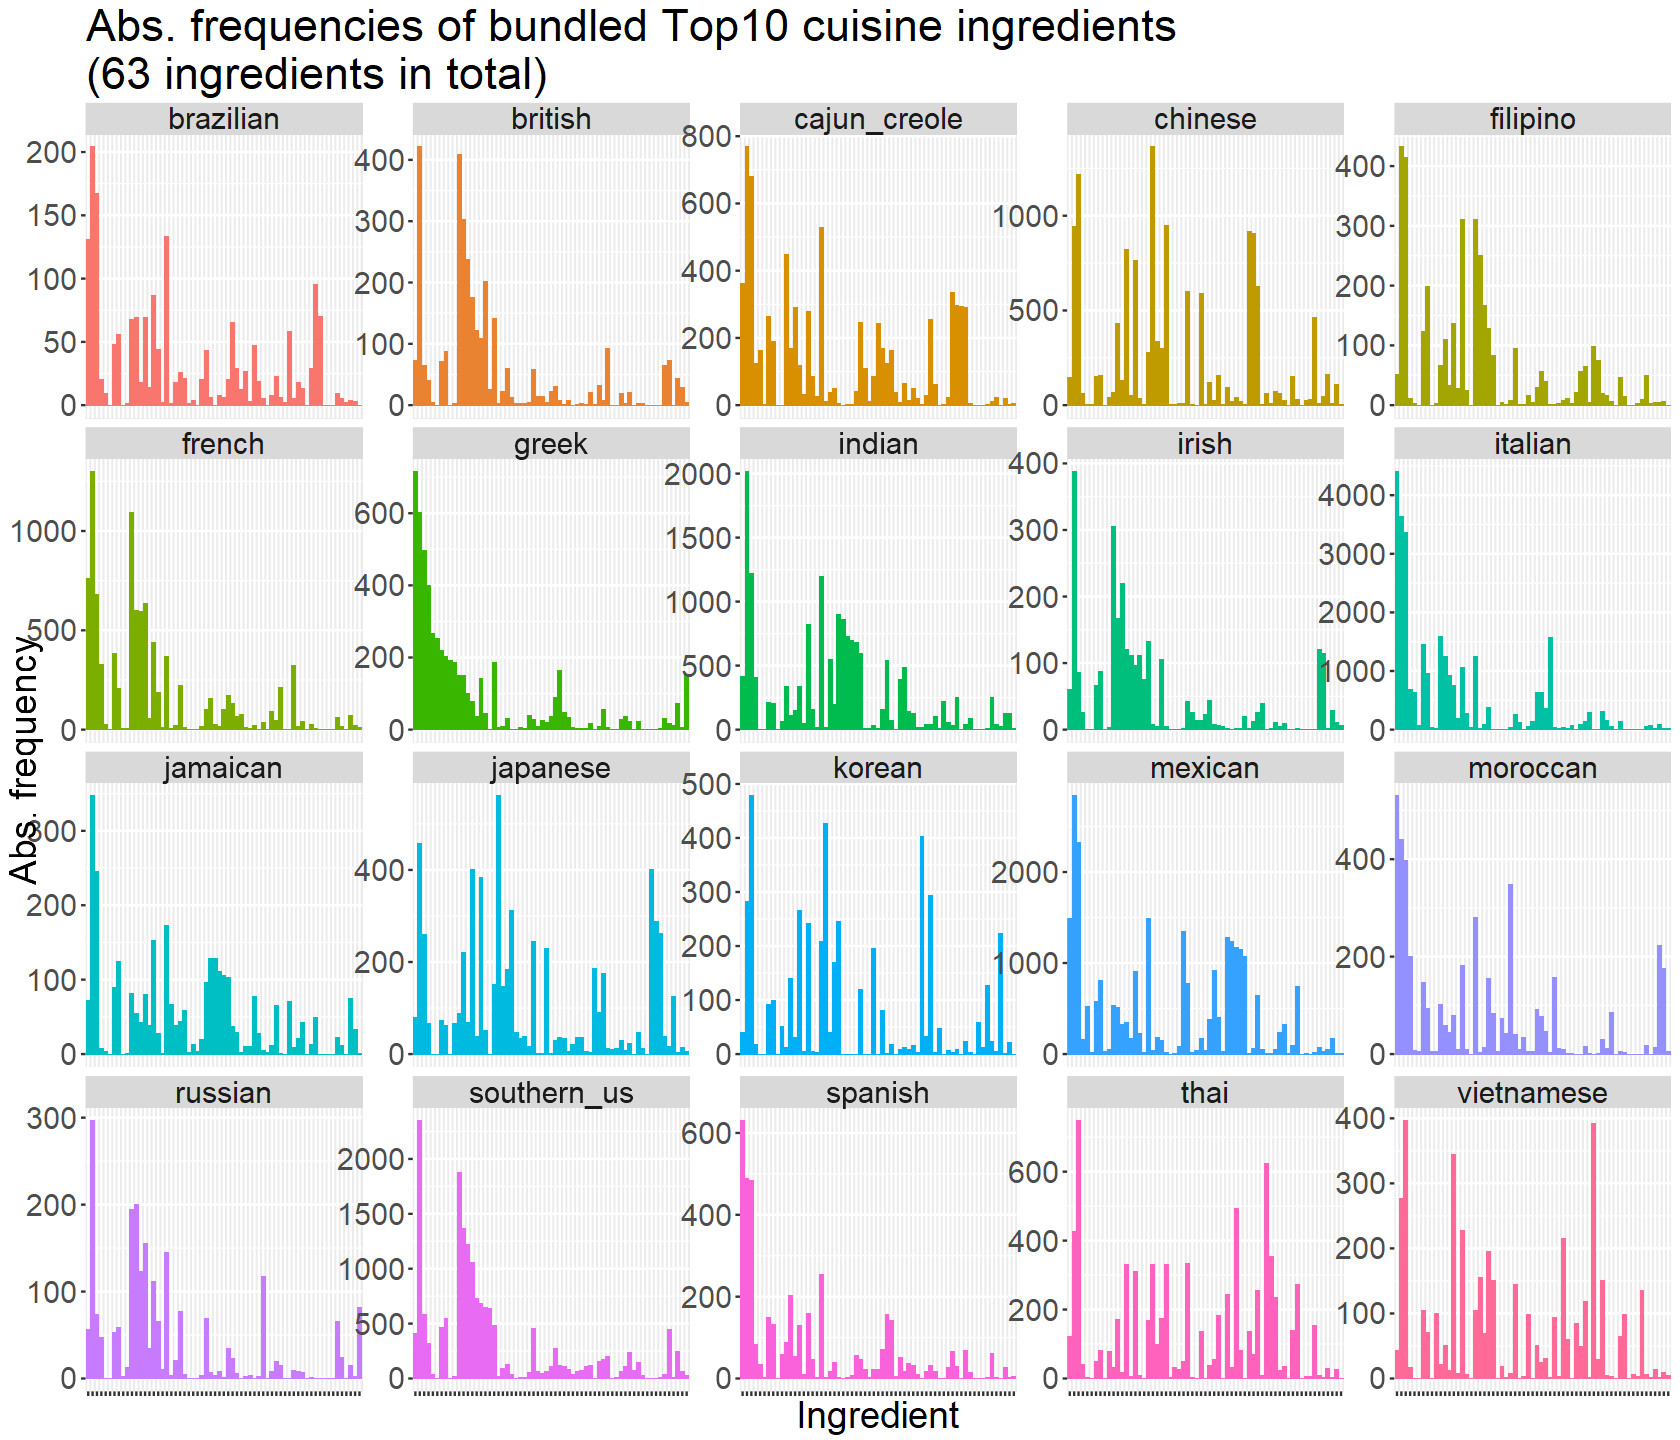

In [29]:
# Top10 ingredients per cuisine
nr_tmp <- 10
ingr_Top_n_cuis <- sapply(cuisine_uni,
                          function (x) {
                            names(d_rec[cuisine == x, sort(table(ingr_new), decreasing = TRUE)][1:nr_tmp])
                          })
ingr_Top_n_cuis_list  <- unique(as.vector(ingr_Top_n_cuis))
d_rec_ingr_Top_n_cuis <- d_rec[ingr_new %in% ingr_Top_n_cuis_list, table(ingr_new, cuisine)]
d_rec_ingr_Top_n_cuis <- d_rec_ingr_Top_n_cuis[ingr_Top_n_cuis_list,]
d_rec_ingr_Top_n_cuis <- setDT(reshape2::melt(d_rec_ingr_Top_n_cuis))
d_rec_ingr_Top_n_cuis <- droplevels(d_rec_ingr_Top_n_cuis)

plot_tmp <- ggplot(d_rec_ingr_Top_n_cuis,
                   aes(x = ingr_new, y = value, group = cuisine, fill = cuisine)) +
              geom_bar(stat = "identity") +
              facet_wrap(~ cuisine, scales = "free_y") +
              theme(legend.position = 'none',
                    axis.text.x = element_blank()) +
              labs(title = paste0("Abs. frequencies of bundled Top", nr_tmp," cuisine ingredients\n",
                                  "(", length(ingr_Top_n_cuis_list), " ingredients in total)")) +
              xlab(paste0("Ingredient")) +
              ylab("Abs. frequency") 
print(plot_tmp, vp = grid::viewport(gp = grid::gpar(cex = 2)))

In [30]:
print(levels(d_rec_ingr_Top_n_cuis$ingr_new))
rm(d_rec_ingr_Top_n_cuis)

 [1] "olive_oil"              "salt"                   "garlic"                
 [4] "lemon_juice"            "dried_oregano"          "feta_cheese_crumbles"  
 [7] "ground_black_pepper"    "pepper"                 "feta_cheese"           
[10] "cucumber"               "butter"                 "eggs"                  
[13] "allpurpose_flour"       "sugar"                  "baking_powder"         
[16] "water"                  "milk"                   "buttermilk"            
[19] "onions"                 "soy_sauce"              "oil"                   
[22] "carrots"                "ginger"                 "garam_masala"          
[25] "ground_turmeric"        "cumin_seed"             "ground_cumin"          
[28] "vegetable_oil"          "thyme"                  "ground_allspice"       
[31] "scallions"              "dried_thyme"            "black_pepper"          
[34] "tomatoes"               "red_bell_pepper"        "grated_parmesan_cheese"
[37] "chopped_cilantro"       "chili_pow

In [31]:
# Top20 ingredients per cuisine
ingr_Top20_per_cuis <- sapply(cuisine_uni,
                              function (x) {
                                names(d_rec[cuisine == x, sort(table(ingr_new), decreasing = TRUE)][1:20])
                              })
ingr_Top20_per_cuis_uni <- unique(as.vector(ingr_Top20_per_cuis))

# Number of unique ingredients
length(ingr_Top20_per_cuis_uni)

# Smallest abs. frequencies of these ingredients
# tab1 <- d_rec[ingr_new %in% ingr_Top20_per_cuis_uni, sort(table(ingr_new), decreasing = TRUE)]
# sort(tab1[ingr_Top20_per_cuis_uni])[1:5]

[1] 112

In [32]:
# Top50 ingredients per cuisine
ingr_Top50_per_cuis <- sapply(cuisine_uni,
                              function (x) {
                                names(d_rec[cuisine == x, sort(table(ingr_new), decreasing = TRUE)][1:50])
                              })
ingr_Top50_per_cuis_uni <- unique(as.vector(ingr_Top50_per_cuis))

# Number of unique ingredients
length(ingr_Top50_per_cuis_uni)

# Smallest abs. frequencies of these ingredients
# tab1 <- d_rec[ingr_new %in% ingr_Top50_per_cuis_uni, sort(table(ingr_new), decreasing = TRUE)]
# sort(tab1[ingr_Top50_per_cuis_uni])[1:5]

[1] 319

## Most most frequent 2-tuples of recipe-ingredients per cuisine

In [33]:
# Calculate most frequent 2-tuples per cuisine (among the 100most frequent cuisine ingredients)  
ingr_set_i_cuis_Top10 <- sapply( cuisine_uni,
                                   function (i) {
                                     cat(paste0(i,", ", which(cuisine_uni == i), "/", length(cuisine_uni)),", \n")
                                     
                                     ingr_set_1_i <- names(d_rec[cuisine == i, sort(table(ingr_new), decreasing = TRUE)][1:100])
                                     
                                     d_i_tmp <- d_rec[ingr_new %in% ingr_set_1_i & cuisine == i, ]
                                     d_i_tmp[, ingr_new := factor(ingr_new)]
                                     d_i_tmp <- setDT(dcast.data.table(d_i_tmp, ID ~ ingr_new,
                                                                       value.var = "ingr_new",
                                                                       fun.aggregate = length))
                                     
                                     ingr_common_i_tmp <- sapply(ingr_set_1_i,
                                                                 function (x) {
                                                                   sapply(ingr_set_1_i,
                                                                          function (y) {
                                                                            sum(d_i_tmp[, rowMeans(.SD) == 1, .SDcols = c(x, y)])
                                                                          })
                                                                 })
                                     ingr_common_i <- sort(unlist( sapply(ingr_set_1_i,
                                                                          function (x) {
                                                                            if (! x == ingr_set_1_i[length(ingr_set_1_i)] ) {
                                                                              sapply(ingr_set_1_i[(which(ingr_set_1_i == x) + 1):length(ingr_set_1_i)],
                                                                                     function (y) {
                                                                                       ingr_common_i_tmp[x, y]
                                                                                     })
                                                                            }
                                                                          }) ), decreasing = TRUE)[1:10]
                                     rm(ingr_common_i_tmp)
                                     
                                     names(ingr_common_i)
                                   })

greek, 1/20 , 
southern_us, 2/20 , 
filipino, 3/20 , 
indian, 4/20 , 
jamaican, 5/20 , 
spanish, 6/20 , 
italian, 7/20 , 
mexican, 8/20 , 
chinese, 9/20 , 
british, 10/20 , 
thai, 11/20 , 
vietnamese, 12/20 , 
cajun_creole, 13/20 , 
brazilian, 14/20 , 
french, 15/20 , 
japanese, 16/20 , 
irish, 17/20 , 
korean, 18/20 , 
moroccan, 19/20 , 
russian, 20/20 , 


In [34]:
# Get 10 most frequent 2-tuples per cuisine 
ingr_Top10_2tuples_cuis_uni <- unique(as.vector(ingr_set_i_cuis_Top10))
# Get single tuple ingredients
ingr_Top10_2tuples_cuis_uni_ingr <- unique(as.vector(sapply(ingr_Top10_2tuples_cuis_uni, 
                                                            function (x) {
                                                              strsplit(x, "\\.")[[1]]
                                                            })))
# Remove duplicates from 2-tuples (like 'a.b' and 'b.a')
Top10_2_tuples_map <- data.table(Tuple = ingr_Top10_2tuples_cuis_uni,
                                 ingr1 = sapply(ingr_Top10_2tuples_cuis_uni, 
                                                function (x) {
                                                  strsplit(x, "\\.")[[1]][1]
                                                }),
                                 ingr2 = sapply(ingr_Top10_2tuples_cuis_uni, 
                                                function (x) {
                                                  strsplit(x, "\\.")[[1]][2]
                                                }))
ingr_Top10_2tuples_cuis_uni2 <- unique(apply(Top10_2_tuples_map[,c(2,3)], 1, 
                                             function (x) { 
                                               paste0( sort(unlist(x)), collapse = "_x_") 
                                             }))
# Length of 10 most frequent 2-tuples across cuisines 
length(ingr_Top10_2tuples_cuis_uni2)

[1] 88

In [35]:
# Get 5 most frequent 2-tuples per cuisine 
ingr_Top5_2tuples_cuis_uni  <- unique(as.vector(apply(ingr_set_i_cuis_Top10, 2, function (x) { x[1:5] })))
# Get single tuple ingredients
ingr_Top5_2tuples_cuis_uni_ingr <- unique(as.vector(sapply(ingr_Top5_2tuples_cuis_uni, 
                                                           function (x) {
                                                             strsplit(x, "\\.")[[1]]
                                                           })))
# Remove duplicates from 2-tuples (like 'a.b' and 'b.a')
Top5_2_tuples_map <- data.table(Tuple = ingr_Top5_2tuples_cuis_uni,
                                ingr1 = sapply(ingr_Top5_2tuples_cuis_uni, 
                                               function (x) {
                                                 strsplit(x, "\\.")[[1]][1]
                                               }),
                                ingr2 = sapply(ingr_Top5_2tuples_cuis_uni, 
                                               function (x) {
                                                 strsplit(x, "\\.")[[1]][2]
                                               }))
ingr_Top5_2tuples_cuis_uni2 <- unique(apply(Top5_2_tuples_map[,c(2,3)], 1, 
                                            function (x) { 
                                              paste0( sort(unlist(x)), collapse = "_x_") 
                                            }))

# Length of 5 most frequent 2-tuples across cuisines
length(ingr_Top5_2tuples_cuis_uni2)
ingr_Top5_2tuples_cuis_uni2

[1] 40

[1] "olive_oil_x_salt"                "garlic_x_olive_oil"             
 [3] "garlic_x_salt"                   "lemon_juice_x_olive_oil"        
 [5] "lemon_juice_x_salt"              "butter_x_salt"                  
 [7] "eggs_x_salt"                     "allpurpose_flour_x_salt"        
 [9] "butter_x_eggs"                   "allpurpose_flour_x_butter"      
[11] "garlic_x_onions"                 "onions_x_salt"                  
[13] "garlic_x_soy_sauce"              "pepper_x_salt"                  
[15] "garam_masala_x_salt"             "garlic_x_ginger"                
[17] "ginger_x_salt"                   "salt_x_water"                   
[19] "salt_x_thyme"                    "olive_oil_x_onions"             
[21] "ground_black_pepper_x_olive_oil" "ground_black_pepper_x_salt"     
[23] "sesame_oil_x_soy_sauce"          "ginger_x_soy_sauce"             
[25] "corn_starch_x_soy_sauce"         "fish_sauce_x_garlic"            
[27] "fish_sauce_x_lime_juice"         "garlic_x_lime_juice"            
[29] "garlic_x_sugar"                  "fish_sauce_x_sugar"             
[31] "fish_sauce_x_water"              "green_bell_pepper_x_onions"     
[33] "mirin_x_soy_sauce"               "soy_sauce_x_sugar"              
[35] "sake_x_soy_sauce"                "mirin_x_sake"                   
[37] "garlic_x_sesame_oil"             "garlic_x_green_onions"          
[39] "ground_cumin_x_olive_oil"        "garlic_x_ground_cumin"

## Most informative cuisine ingredients: TF-IDF

In [36]:
# Calculate TF-IDF
d_rec_tdfi_cu <- d_rec %>%
  count(cuisine, ingr_new) %>%
  tidytext::bind_tf_idf(term = ingr_new, document = cuisine, n = n)
tf_idf_max_cuis <- (sapply(cuisine_uni, 
                           function (i) {
                             d_rec_tdfi_cu[ cuisine == i, ][order(tf_idf, decreasing = TRUE), ingr_new[1]]
                           }))
d_rec_tdfi_cu[, n   := NULL]
d_rec_tdfi_cu[, tf  := NULL]
d_rec_tdfi_cu[, idf := NULL]

# Print ingredient with highest TF-IDF value for each cuisine
print(tf_idf_max_cuis, max.levels = 0)

               greek          southern_us             filipino 
feta_cheese_crumbles                grits           fish_sauce 
              indian             jamaican              spanish 
        garam_masala  scotch_bonnet_chile      saffron_threads 
             italian              mexican              chinese 
     lasagna_noodles        refried_beans        shaoxing_wine 
             british                 thai           vietnamese 
      stilton_cheese           fish_sauce           fish_sauce 
        cajun_creole            brazilian               french 
        cajun_soning              cachaca       gruyere_cheese 
            japanese                irish               korean 
               mirin        irish_whiskey       gochujang_base 
            moroccan              russian 
            couscous           sauerkraut 


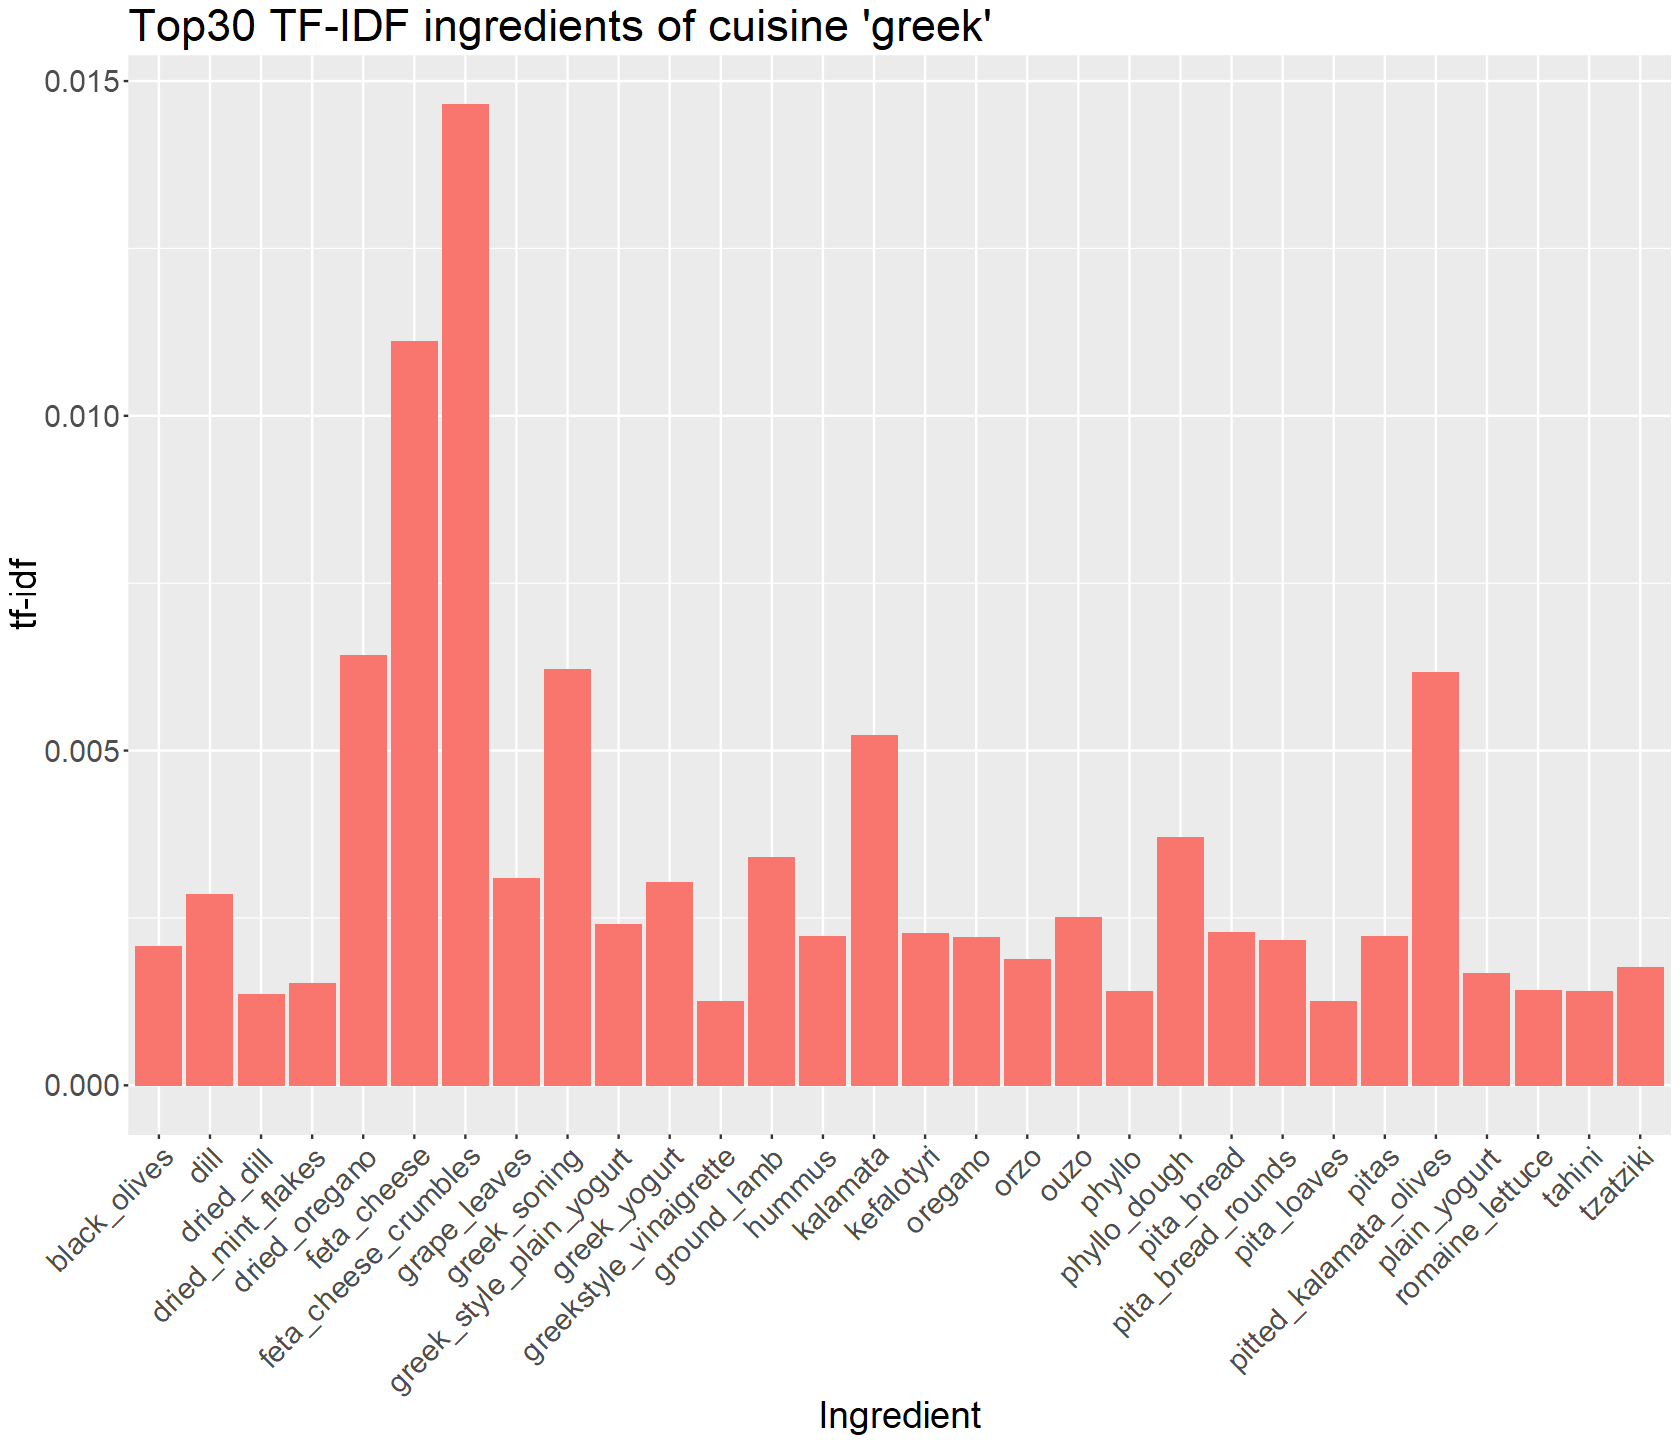

In [37]:
# Print Top30 TF-IDF ingredients for cuisine 'greek'
ingr_tmp <- d_rec_tdfi_cu[ cuisine == "greek", ][order(tf_idf, decreasing = TRUE), ingr_new[1:30]]
plot_tmp <- ggplot(d_rec_tdfi_cu[cuisine == "greek" & ingr_new %in% ingr_tmp, ],
                   aes(x = ingr_new, y = tf_idf, fill = cuisine, group = cuisine)) +
              geom_bar(stat = "identity") +
              theme(legend.position = "none",
                    axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1)) +
              labs(title = "Top30 TF-IDF ingredients of cuisine 'greek' ") +
              ylab("tf-idf") +
              xlab("Ingredient")
print(plot_tmp, vp = grid::viewport(gp = grid::gpar(cex = 2)))

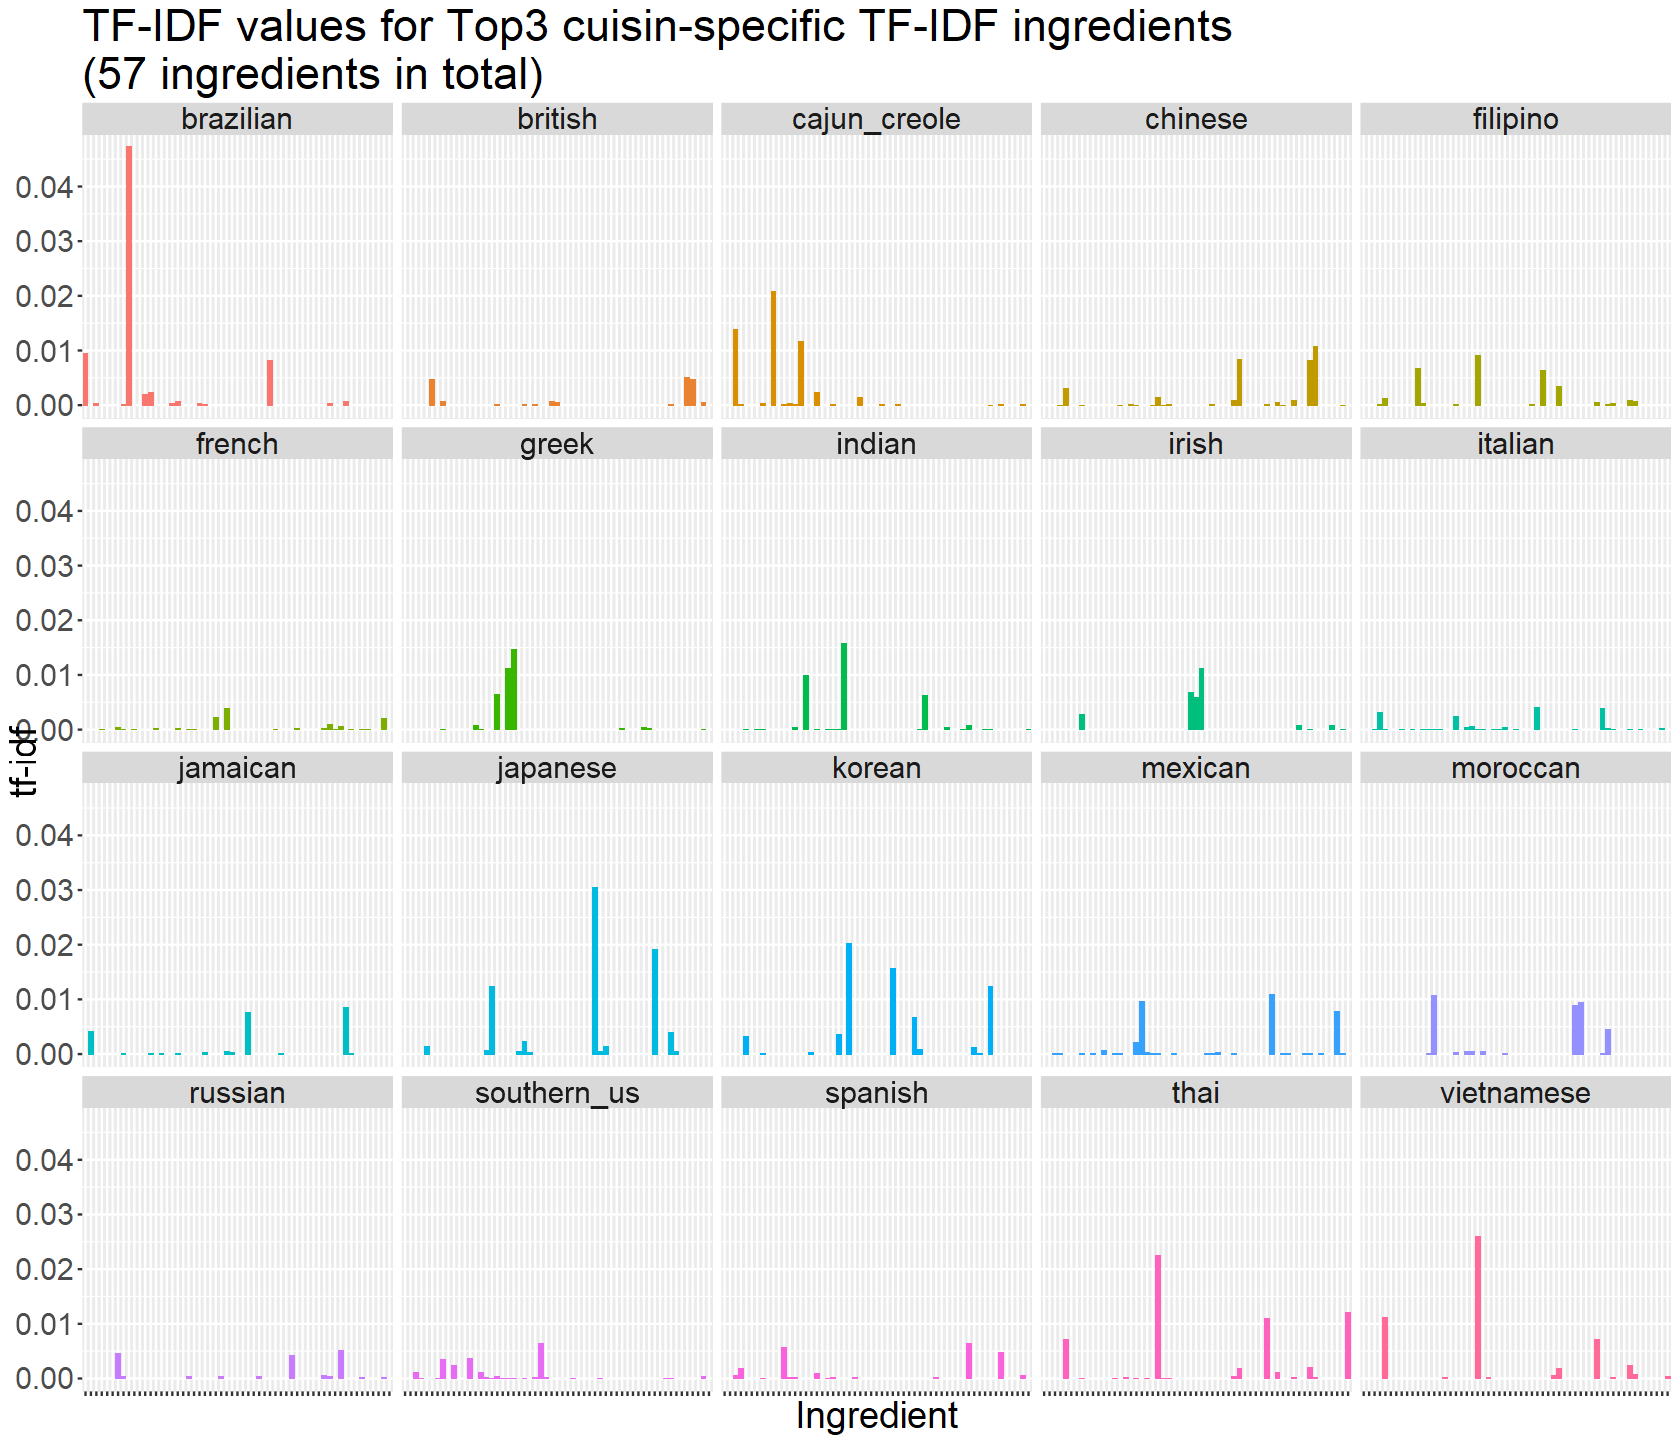

In [38]:
# Plot TF-IDF
n_tmp <- 3
ingr_tmp <- sapply(cuisine_uni, 
                   function (i) {
                     d_rec_tdfi_cu[ cuisine == i, ][order(tf_idf, decreasing = TRUE), ingr_new[1:n_tmp]]
                   })
ingr_tmp <- unique(as.vector(ingr_tmp))
plot_tmp <- ggplot(d_rec_tdfi_cu[ingr_new %in% ingr_tmp, ],
                   aes(x = ingr_new, y = tf_idf, fill = cuisine, group = cuisine)) +
              geom_bar(stat = "identity") +
              facet_wrap(~cuisine) +
              theme(legend.position = "none",
                    axis.text.x = element_blank()) +
              labs(title = paste0("TF-IDF values for Top", n_tmp, " cuisin-specific TF-IDF ingredients\n",
                                  "(", length(ingr_tmp), " ingredients in total)")) +
              ylab("tf-idf") +
              xlab("Ingredient")
print(plot_tmp, vp = grid::viewport(gp = grid::gpar(cex = 2)))

In [39]:
# Print ingredients of the plot
print(levels(d_rec_tdfi_cu$ingr_new)[levels(d_rec_tdfi_cu$ingr_new) %in% ingr_tmp])

 [1] "acai"                  "ackee"                 "andouille_sausage"    
 [4] "arborio_rice"          "beansprouts"           "beef_drippings"       
 [7] "buckwheat_flour"       "buttermilk"            "cachaca"              
[10] "cajun_soning"          "calamansi_juice"       "chorizo_sausage"      
[13] "collard_greens"        "couscous"              "creole_soning"        
[16] "curry_leaves"          "dashi"                 "dried_oregano"        
[19] "enchilada_sauce"       "feta_cheese"           "feta_cheese_crumbles" 
[22] "fish_sauce"            "garam_masala"          "gochujang_base"       
[25] "grated_gruyere_cheese" "grits"                 "gruyere_cheese"       
[28] "guinness_beer"         "irish_cream_liqueur"   "irish_whiskey"        
[31] "jamaican_jerk_son"     "kimchi"                "lasagna_noodles"      
[34] "lumpia_wrappers"       "manioc_flour"          "mirin"                
[37] "oyster_sauce"          "paneer"                "pierogi"              

In [40]:
# Take Top5 TF-IDF ingredients per cuisine
ingr_tfidf_Top5_cuis <- unique(as.vector(sapply(cuisine_uni, 
                                                function (i) {
                                                  d_rec_tdfi_cu[ cuisine == i, ][order(tf_idf, decreasing = TRUE), ingr_new[1:5]]
                                                })))
# Total number of bundled Top5 TF-IDF ingredients across cuisines
length(ingr_tfidf_Top5_cuis)

[1] 95

In [41]:
# 10 Smallest abs. frequencies of the Top5 TF-IDF ingredients in the data
tab1 <- d_rec[ingr_new %in% ingr_tfidf_Top5_cuis, sort(table(ingr_new), decreasing = TRUE)]
sort(tab1[ingr_tfidf_Top5_cuis], decreasing = FALSE)[1:10]

ingr_new
   irish_bacon        pierogi          ackee       callaloo    jerk_soning 
             7              7              9              9              9 
       stilton   lumpia_skins beef_drippings   manioc_flour       palm_oil 
             9             10             12             12             12 

In [42]:
# Take Top10 TF-IDF ingredients per cuisine
ingr_tfidf_Top10_cuis <- unique(as.vector(sapply(cuisine_uni, 
                                                 function (i) {
                                                   d_rec_tdfi_cu[ cuisine == i, ][order(tf_idf, decreasing = TRUE), ingr_new[1:10]]
                                                 })))
# Total number of bundled Top10 TF-IDF ingredients across cuisines
length(ingr_tfidf_Top10_cuis)

[1] 182

In [43]:
rm(d_rec_tdfi_cu)

## Define ingredient set for classification

In [44]:
# ingredient set for classification
ingr_aux <- unique(c(ingr_Top50_per_cuis_uni,
                       ingr_Top10_2tuples_cuis_uni_ingr,
                       ingr_tfidf_Top10_cuis))
cat(paste0("Ingredient set 'ingr_aux' contains:\n",
           "- Top50 most frequent cuisine ingredients combined (", length(ingr_Top50_per_cuis_uni), " different ingredients)\n",
           "- Top10 of most frequent cuisine 2-tuples combined (", length(ingr_Top10_2tuples_cuis_uni2), " different ingredients)\n",
           "- Top10 cuisine TF-IDF ingredients combined (", length(ingr_tfidf_Top10_cuis), " different ingredients)\n",
           "\nTogether this is a total of ", 
           length(ingr_aux) + length(ingr_Top10_2tuples_cuis_uni_ingr),
           " unique ingredients.\nThe total number of unique ingredients in the data is ",
           d_rec[, length(unique(ingr_new))], ".\n\n",
           round(d_rec[ingr_new %in% ingr_aux, length(unique(ID))] / d_rec[, length(unique(ID))] * 100, digits = 2),
           "% of all recipes contain at least one of the ingredients in 'ingr_aux'."
))

Ingredient set 'ingr_aux' contains:
- Top50 most frequent cuisine ingredients combined (319 different ingredients)
- Top10 of most frequent cuisine 2-tuples combined (88 different ingredients)
- Top10 cuisine TF-IDF ingredients combined (182 different ingredients)

Together this is a total of 450 unique ingredients.
The total number of unique ingredients in the data is 6564.

99.51% of all recipes contain at least one of the ingredients in 'ingr_aux'.

In [45]:
# Larger set: Set of all ingredients which appear at least 5 times + ingr_aux
ingr_aux_large <- names(d_rec[, sort(table(ingr_new)[table(ingr_new) >= 5], decreasing = TRUE)])
ingr_aux_large <- unique(c(ingr_aux_large, ingr_aux))
length(ingr_aux_large)
d_rec[, length(unique(ingr_new))]

[1] 3257

[1] 6564

# Similarities of recipes and cuisines  <a class="anchor" id="bullet4"></a>

## Similarity of recipes

In [46]:
# For the similarity measures, we consider 'ingr_aux_large', 
# i.e. the reduced set of 3257 ingredients

# Calculate TF-IDF
d_rec_tdfi_cu <- d_rec[ingr_new %in% ingr_aux_large,] %>%
  count(cuisine, ingr_new) %>%
  tidytext::bind_tf_idf(term = ingr_new, document = cuisine, n = n)
  
# Merge TF-IDF values to 'd_rec'
d_tmp <- merge.data.table(d_rec[ingr_new %in% ingr_aux_large,], 
                          d_rec_tdfi_cu[, c("cuisine", "ingr_new", "tf_idf")], 
                          by = c("cuisine", "ingr_new"), 
                          all = TRUE, 
                          sort = FALSE)
  
# Transform data to long format
d_tmp2 <- setDT(dcast.data.table(d_tmp[ingr_new %in% ingr_aux_large],
                                 ID + cuisine ~ ingr_new, 
                                 value.var = "tf_idf",
                                 fill = 0))
rm(d_tmp)

In [47]:
# Sample 1 recipe
set.seed(96)
ID_samp <- d_tmp2[, sample(unique(ID), 1)]
  
# Sample 5000 recipes to compare it with
set.seed(76)
ID_samp2 <- sample(d_tmp2[, unique(ID)[!unique(ID) %in% ID_samp]], 5000)
  
# Calculate cosine similarity of recipes
b_tmp <- unlist(d_tmp2[ID == ID_samp, -c("ID", "cuisine")])
cos_ID_samp <- sapply(ID_samp2, 
                      function (x) {
                        as.numeric(lsa::cosine(unlist(d_tmp2[ID == x, -c("ID", "cuisine")]), b_tmp))
                      })
rm(d_tmp2)
cos_ID_samp <- data.table(cosine_sim = cos_ID_samp, 
                          ID = ID_samp2)

In [48]:
# Chosen recipe
print(d_rec[ID == ID_samp, unique(cuisine)], max.levels = 0)
print(d_rec[ID == ID_samp, ingr_new], max.levels = 0)
cat("\n\n")  

# Cosine: Most similar recipe
print(d_rec[ID == cos_ID_samp[order(cosine_sim, decreasing = TRUE), ID[1]], unique(cuisine)], max.levels = 0)
print(d_rec[ID == cos_ID_samp[order(cosine_sim, decreasing = TRUE), ID[1]], ingr_new], max.levels = 0)
cat("\n\n") 

# Cosine: Most un-similar recipe
print(d_rec[ID == cos_ID_samp[order(cosine_sim, decreasing = FALSE), ID[1]], unique(cuisine)], max.levels = 0)
print(d_rec[ID == cos_ID_samp[order(cosine_sim, decreasing = FALSE), ID[1]], ingr_new], max.levels = 0)
cat("\n\n")   


[1] indian
 [1] tomatoes           coriander_seeds    cinnamon           green_cardamom    
 [5] cumin_seed         ginger_paste       red_chili_peppers  whole_garam_masala
 [9] salt               green_chilies      onions             tumeric           
[13] coriander_powder   kasuri_methi       brown_cardamom     oil               
[17] ground_cumin       clove              water              garbonzo_bean     
[21] cilantro_leaves    liquid             masala            


[1] indian
 [1] minced_garlic    vinegar          salt             onions          
 [5] tomatoes         coriander_powder poppy_seeds      green_chilies   
 [9] ground_turmeric  minced_ginger    chili_powder     cilantro_leaves 
[13] cashew_nuts      grated_coconut   beef             garlic          
[17] oil              masala          


[1] italian
[1] boneless_skinless_chicken_breasts eggs                             
[3] allpurpose_flour                  chicken_stock                    
[5] butter          

In [49]:
# Chosen ingredients and their TF-IDF value
d_rec_tdfi_cu[ingr_new == "green_chilies", c("cuisine", "tf_idf")][order(tf_idf, decreasing = TRUE),][1:5,]
d_rec_tdfi_cu[ingr_new == "oil",           c("cuisine", "tf_idf")][order(tf_idf, decreasing = TRUE),][1:5,]
d_rec_tdfi_cu[ingr_new == "salt",          c("cuisine", "tf_idf")][order(tf_idf, decreasing = TRUE),][1:5,]
 
rm(cos_ID_samp)

cuisine  tf_idf      
1 indian   0.0036836457
2 mexican  0.0006913332
3 japanese 0.0006593822
4 filipino 0.0005834547
5 korean   0.0005284274

cuisine      tf_idf
1 brazilian    0     
2 british      0     
3 cajun_creole 0     
4 chinese      0     
5 filipino     0

cuisine      tf_idf
1 brazilian    0     
2 british      0     
3 cajun_creole 0     
4 chinese      0     
5 filipino     0

## Similarity of cuisines

### Cosine similarity of cuisines based on ingredient set 'ingr_aux_large'

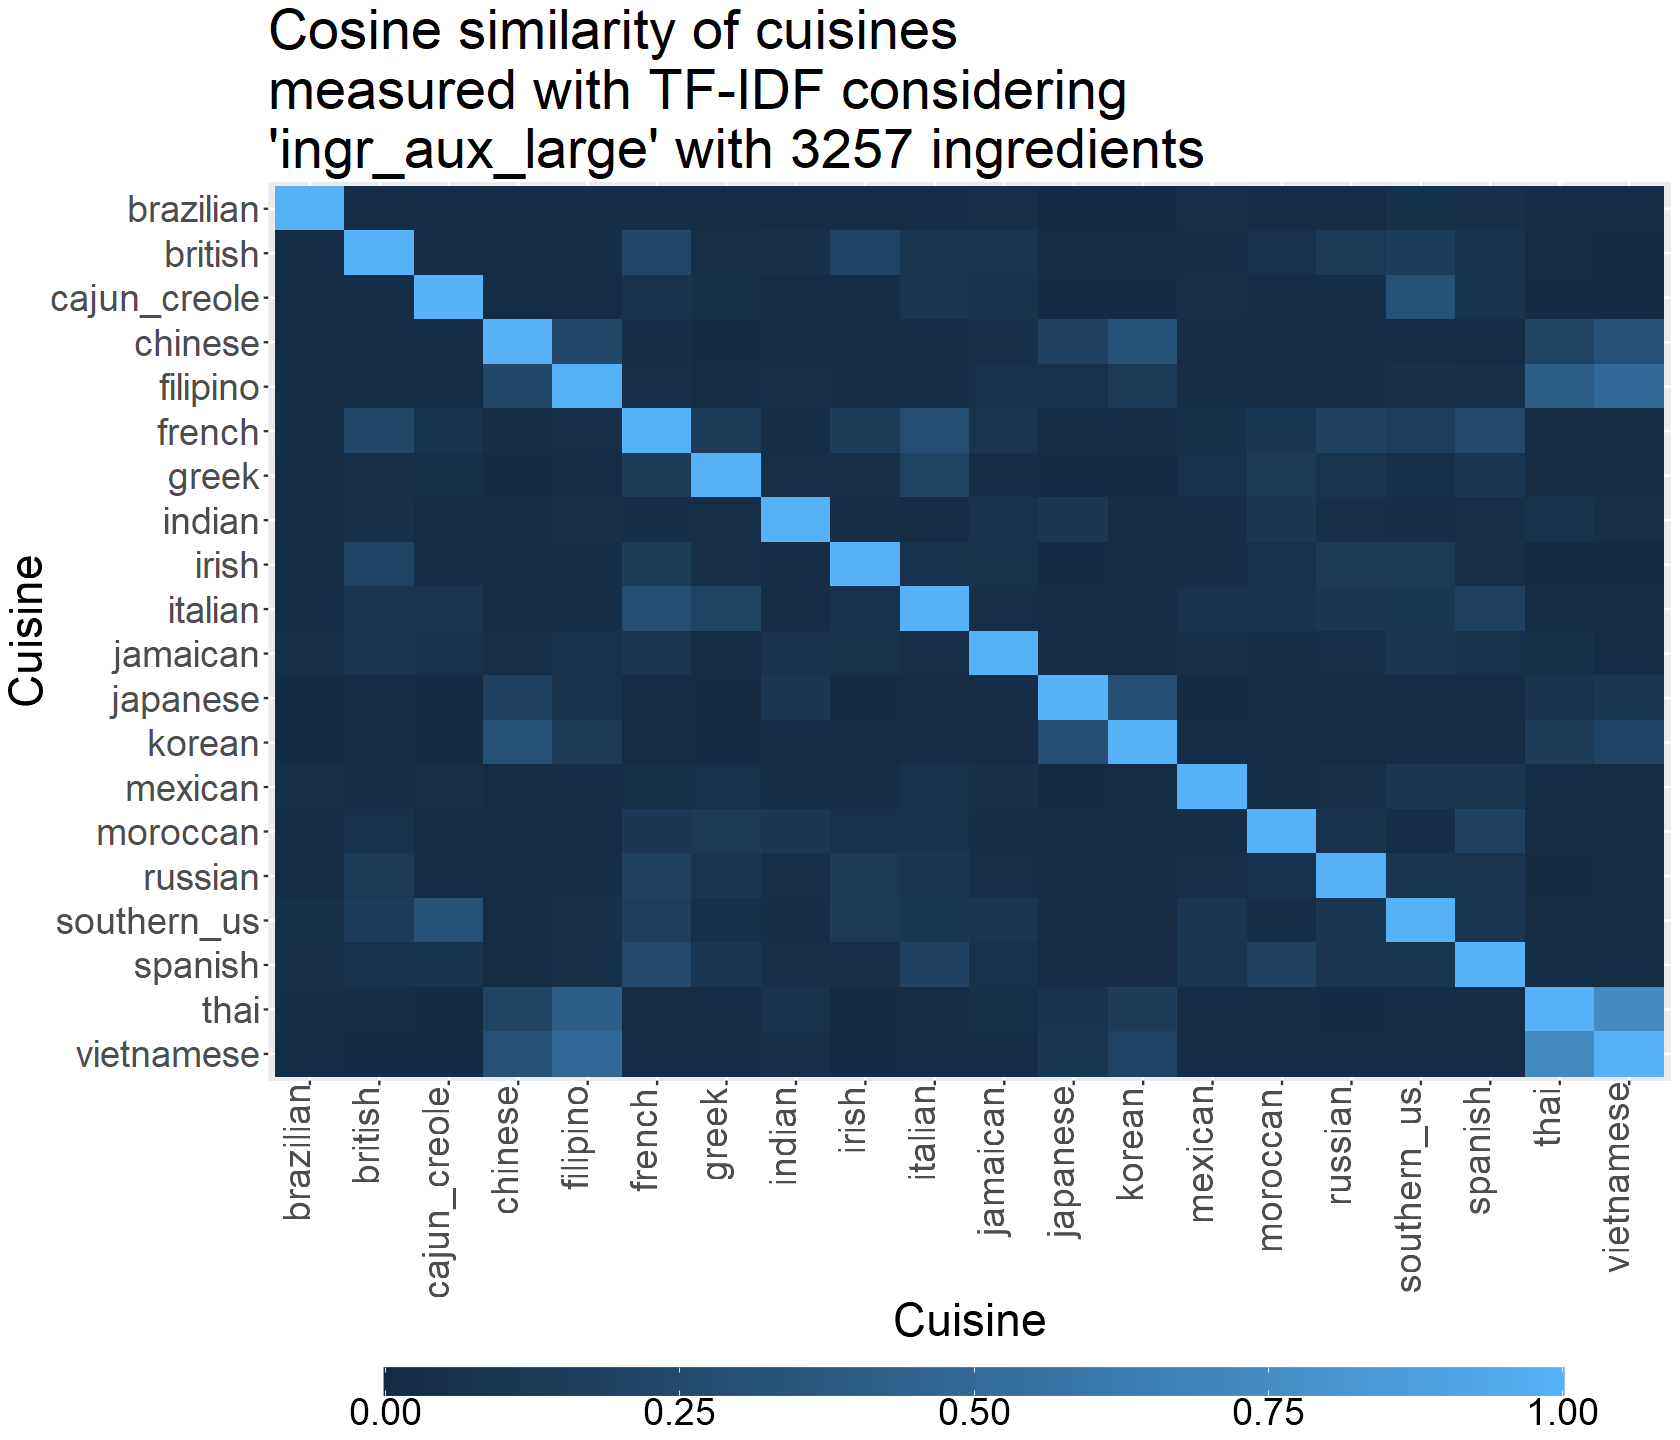

In [50]:
# Calculate TF-IDF
d_rec_tdfi_cu <- d_rec[ingr_new %in% ingr_aux_large,] %>%
  count(cuisine, ingr_new) %>%
  tidytext::bind_tf_idf(term = ingr_new, document = cuisine, n = n)
d_tmp <- setDT(dcast.data.table(d_rec_tdfi_cu[ingr_new %in% ingr_aux_large, c("cuisine", "ingr_new", "tf_idf")],
                                cuisine ~ ingr_new, 
                                value.var = "tf_idf",
                                fill = 0))

# Calculate cosine similarity
cos_mat_tmp <- lsa::cosine(t(as.matrix(d_tmp[,-("cuisine")])))
rownames(cos_mat_tmp) <- colnames(cos_mat_tmp) <- as.vector(d_tmp$cuisine)

# Plot cosine similarities
dat_plot <- as.data.table(reshape2::melt(cos_mat_tmp))
dat_plot <- dat_plot %>%
  mutate(Var1 = factor(Var1), 
         Var2  = factor(Var2, levels = rev(unique(Var2))))

plot_tmp <- ggplot(dat_plot, 
                   aes(x = Var1, y = Var2, fill = value)) + 
              geom_tile() +
              scale_fill_gradient(limits = c(0, 1)) +
              theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0),
                    legend.position = "bottom") +
              labs(title = paste0("Cosine similarity of cuisines\n","measured with TF-IDF considering ", 
                                  "\n'ingr_aux_large' with ", length(ingr_aux_large), " ingredients")) +
              ylab("Cuisine") +
              xlab("Cuisine") +
              theme(legend.key.width = unit(5, 'cm'),
                   legend.title = element_blank())

print(plot_tmp, vp = grid::viewport(gp = grid::gpar(cex = 2.5)))

### Cosine similarity of cuisines based on ingredient set 'ingr_aux'

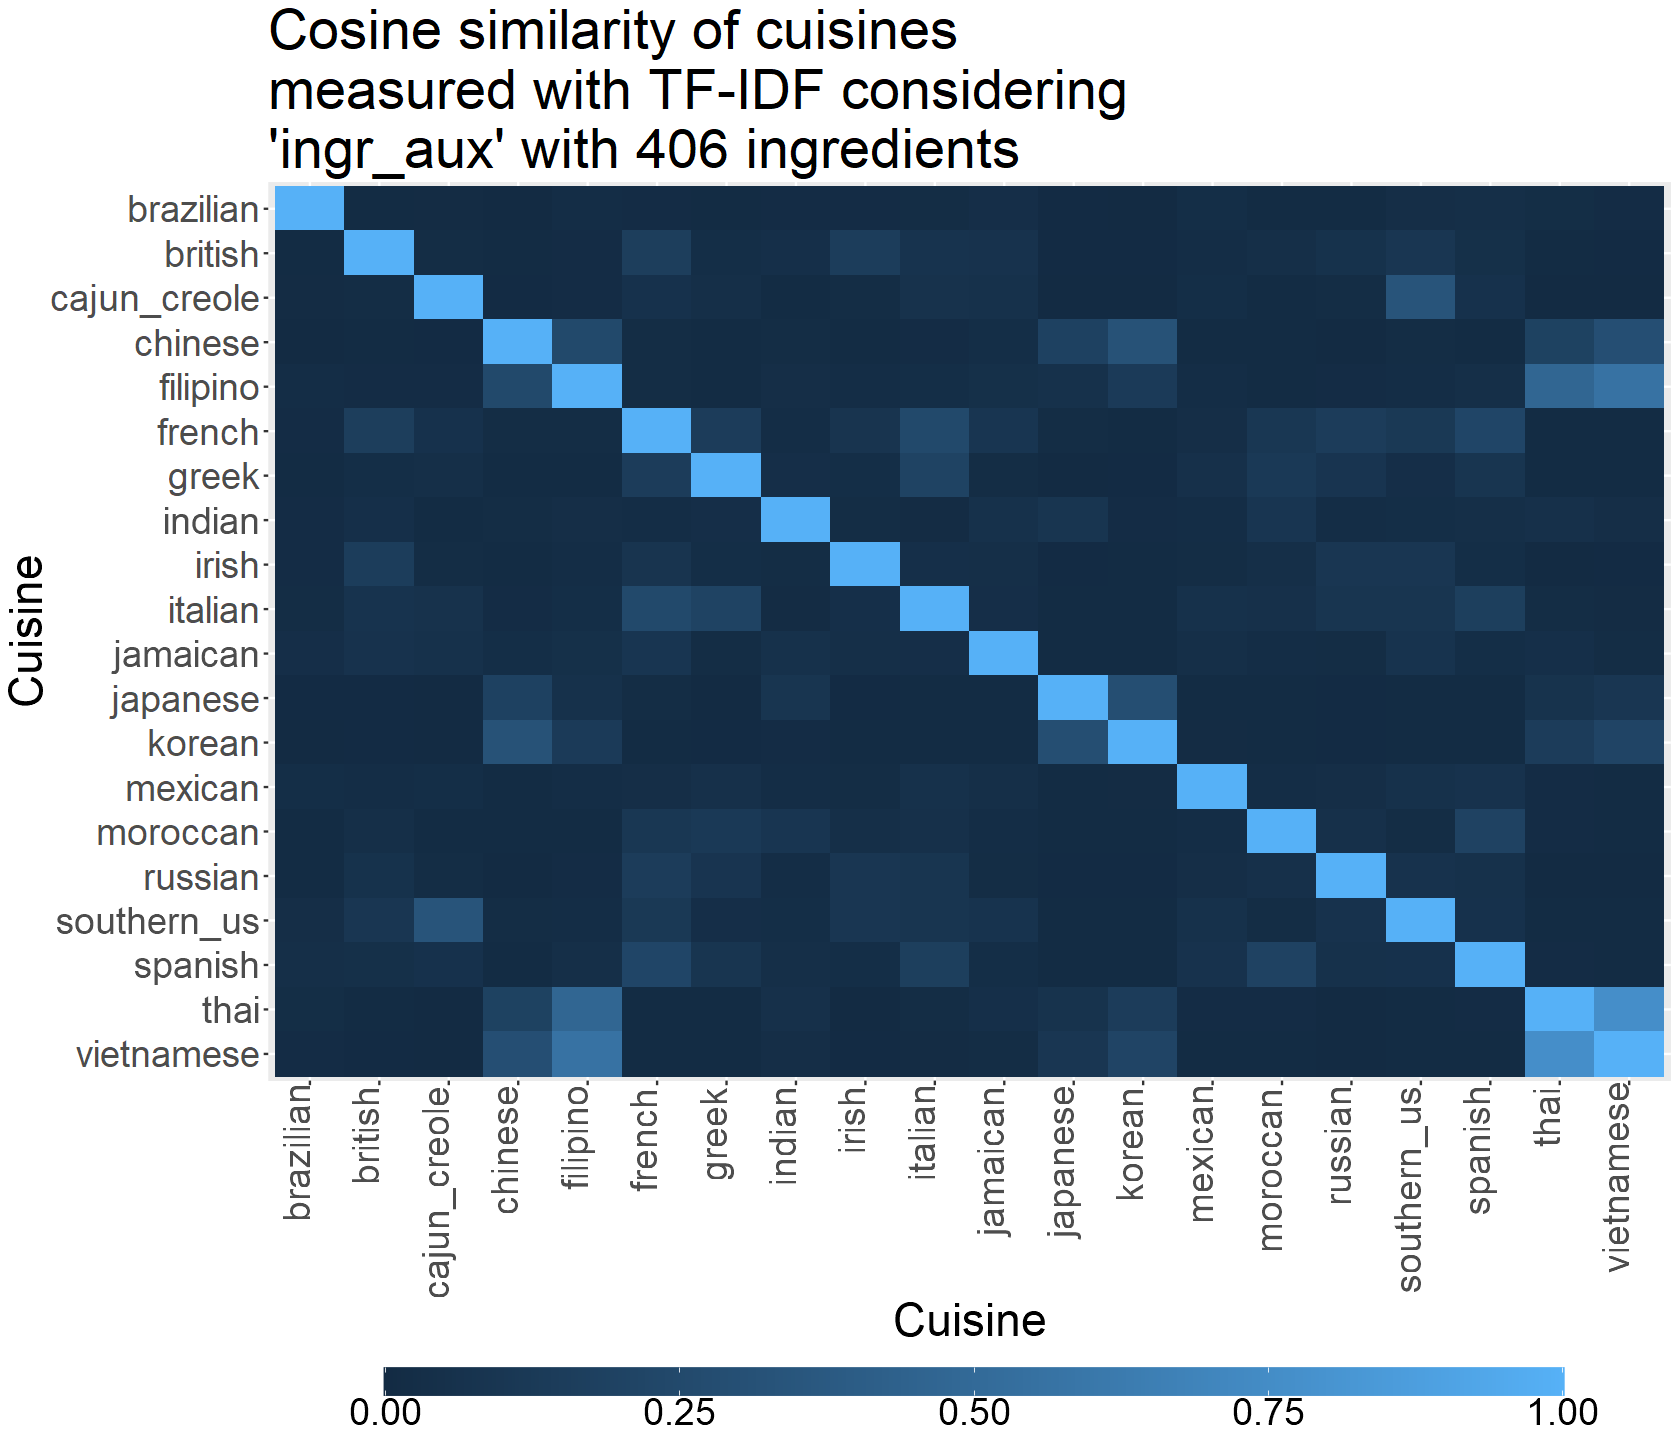

In [51]:
# Calculate TF-IDF
d_rec_tdfi_cu <- d_rec[ingr_new %in% ingr_aux,] %>%
  count(cuisine, ingr_new) %>%
  tidytext::bind_tf_idf(term = ingr_new, document = cuisine, n = n)
d_tmp <- setDT(dcast.data.table(d_rec_tdfi_cu[ingr_new %in% ingr_aux, c("cuisine", "ingr_new", "tf_idf")],
                                cuisine ~ ingr_new, 
                                value.var = "tf_idf",
                                fill = 0))

# Calculate cosine similarity
cos_mat_tmp <- lsa::cosine(t(as.matrix(d_tmp[,-("cuisine")])))
rownames(cos_mat_tmp) <- colnames(cos_mat_tmp) <- as.vector(d_tmp$cuisine)

# Plot cosine similarities
dat_plot <- as.data.table(reshape2::melt(cos_mat_tmp))
dat_plot <- dat_plot %>%
  mutate(Var1 = factor(Var1), 
         Var2  = factor(Var2, levels = rev(unique(Var2))))


plot_tmp <- ggplot(dat_plot, 
                   aes(x = Var1, y = Var2, fill = value)) + 
  geom_tile() +
  scale_fill_gradient(limits = c(0, 1)) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0),
        legend.position = "bottom") +
              labs(title = paste0("Cosine similarity of cuisines\n","measured with TF-IDF considering ", 
                                  "\n'ingr_aux' with ", length(ingr_aux), " ingredients")) +
  ylab("Cuisine") +
  xlab("Cuisine") +
  theme(legend.key.width = unit(5, 'cm'),
        legend.title = element_blank())

print(plot_tmp, vp = grid::viewport(gp = grid::gpar(cex = 2.5)))

In [52]:
rm(d_tmp)
rm(dat_plot)
rm(cos_mat_tmp)

## Similarity of cuisine recipes

In [53]:
# Sample recipes
set.seed(876) 
ID_samp3 <- sample(d_rec[, unique(ID)], 7000, replace = FALSE)

### T-SNE visualization based on the ingredients in 'ingr_aux' (dummies) and 7000 sampled recipes

In [54]:
# Long-format data with ingredient dummies
d_samp <- setDT(dcast.data.table(d_rec[ID %in% ID_samp3 & ingr_new %in% ingr_aux, ],
                                 ID + cuisine ~ ingr_new, 
                                 value.var = "ingr_new",
                                 fun.aggregate = length))
# Remove duplicates
dim(d_samp)
dupl_rows        <- duplicated(d_samp[, -c("ID", "cuisine")])
d_samp           <- d_samp[!dupl_rows, ]
dim(d_samp)

# Calculate T-SNE
tsne_res_dummy_1 <- Rtsne::Rtsne(d_samp[, -c("ID", "cuisine")],
                                 dims = 2, 
                                 pca = FALSE,
                                 check_duplicates = FALSE,
                                 perplexity = 100)

[1] 6960  402

[1] 6821  402

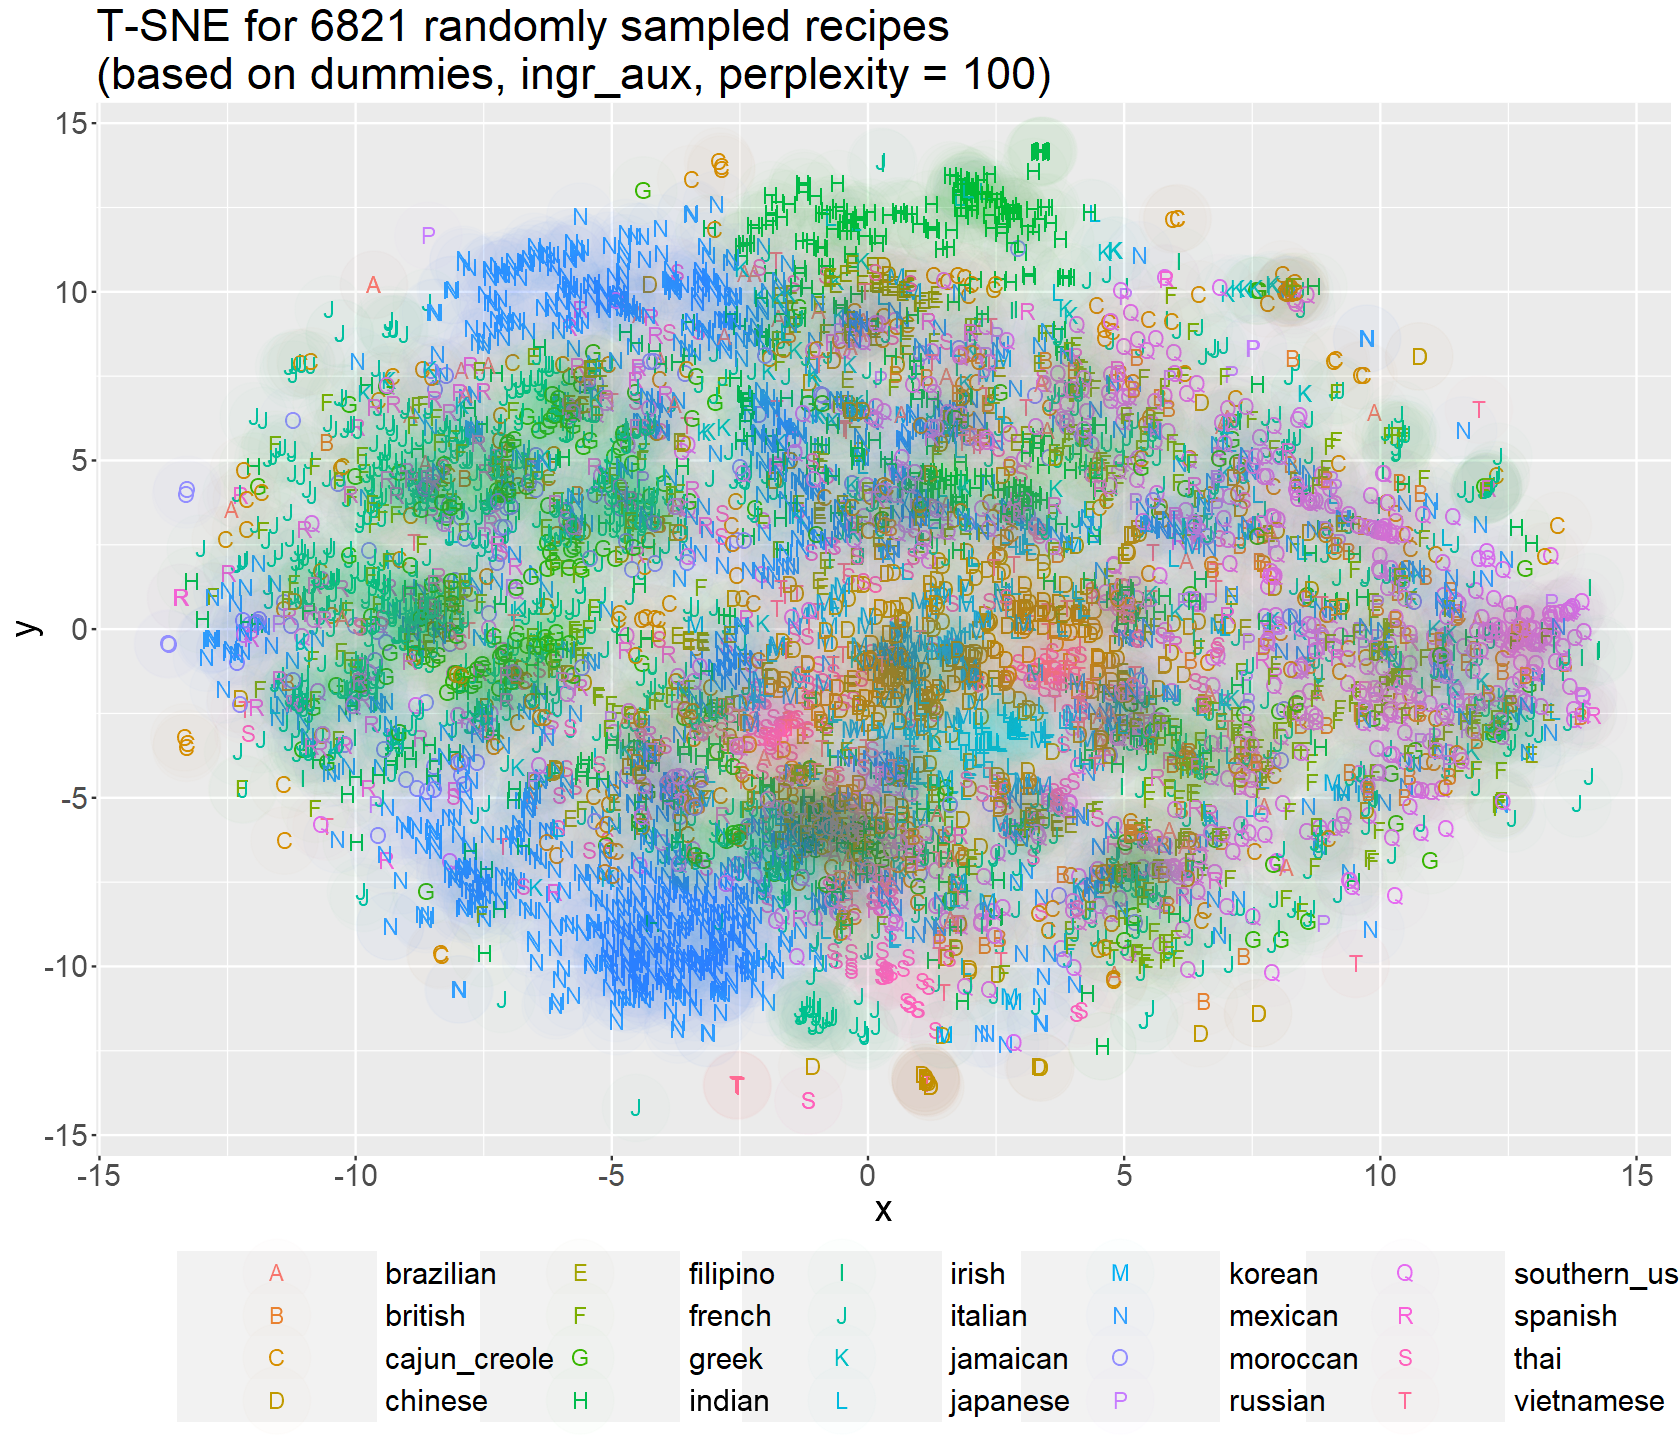

In [55]:
# Plot T-SNE
plot_tmp <- ggplot(data.table(x = tsne_res_dummy_1$Y[,1],
                              y = tsne_res_dummy_1$Y[,2],
                              cuisine = factor(d_samp$cuisine)),
                   aes(x = x, y = y, color = cuisine, fill = cuisine, shape = cuisine)) +
  geom_point(alpha = 1, size = 2) +
  geom_point(alpha = .01, pch = 21, size = 9) +
  scale_shape_manual(values = LETTERS[1:length(cuisine_uni)]) +
  theme(legend.position = "bottom") +
  labs(title = paste0("T-SNE for ", nrow(d_samp), 
                      " randomly sampled recipes\n(based on dummies, ingr_aux, perplexity = 100)")) +
  theme(legend.key.width = unit(4.2, 'cm'),
        legend.title = element_blank())

print(plot_tmp, vp = grid::viewport(gp = grid::gpar(cex = 2)))

In [56]:
rm(tsne_res_dummy_1)
rm(d_samp)

# Classification of recipe cuisines  <a class="anchor" id="bullet5"></a>

## Auxiliary matrix

In [57]:
# Set up the auxiliary matrix based on ingr_aux
d_rec_ingr_aux <- d_rec[ingr_new %in% ingr_aux, ]
d_rec_ingr_aux <- setDT(dcast.data.table(d_rec_ingr_aux,
                                           ID + cuisine ~ ingr_new, 
                                           value.var = "ingr_new",
                                           fun.aggregate = length))

# Add the ingredient interactions: The combined Top10 2-tuples of each cuisine
for ( i in ingr_Top10_2tuples_cuis_uni ) {
  a_tmp <- strsplit(i, "\\.")[[1]][1]
  b_tmp <- strsplit(i, "\\.")[[1]][2]
  c_tmp <- d_rec_ingr_aux[, ..a_tmp] * d_rec_ingr_aux[, ..b_tmp]
  d_rec_ingr_aux[, XXX := c_tmp]
  colnames(d_rec_ingr_aux)[length(colnames(d_rec_ingr_aux))] <- paste0(a_tmp, "_x_", b_tmp)
}

# Check data for duplicate columns
dupl_cols <- duplicated(t(d_rec_ingr_aux))
table(dupl_cols)
a_tmp <- colnames(d_rec_ingr_aux)[!dupl_cols]
d_rec_ingr_aux <- d_rec_ingr_aux[, .SD, .SDcols = a_tmp]

# Column names of ingr_aux
ingr_aux_colnames <- colnames(d_rec_ingr_aux)[!colnames(d_rec_ingr_aux) %in% c("ID", "cuisine")]

cat(paste0(
  "Data 'd_rec_ingr_aux'",
  " accounts for ", 
  round(d_rec_ingr_aux[, length(unique(ID))] / d_rec[, length(unique(ID))] * 100, digits = 2),
  "% of all recipes.\n",
  "It contains ", 
  dim(d_rec_ingr_aux)[1],
  " data rows and ",
  dim(d_rec_ingr_aux)[2],
  " features"
))

dupl_cols
FALSE  TRUE 
  496     9 

Data 'd_rec_ingr_aux' accounts for 99.51% of all recipes.
It contains 39580 data rows and 496 features

In [58]:
# Are there duplicate recipes?
table(duplicated(d_rec_ingr_aux[, - "ID"]))
table(duplicated(d_rec_ingr_aux[, - c("ID", "cuisine")]))


FALSE  TRUE 
37834  1746 


FALSE  TRUE 
37188  2392 

## Function for evaluation of algorithms

In [59]:
f_eval <- function(mod_name) {
  
  out_caret_train <- caret::confusionMatrix(reference = d_CV$SAMP1$cuisine,
                                            data      = model_results[[mod_name]]$predicted_classes_train,
                                            mode      = "everything")
  out_caret_test <- caret::confusionMatrix(reference = d_CV$SAMP2$cuisine,
                                           data      = model_results[[mod_name]]$predicted_classes_test,
                                           mode      = "everything")
  
  cat(paste0("\n\nModel = ", mod_name, "\n", 
             "overall accuracy training data = ", round(out_caret_train$overall["Accuracy"],  digits = 2), "\n",
             "overall accuracy test data = ",     round(out_caret_test$overall["Accuracy"],   digits = 2),"\n",             
             "macro f1 training data = ",         round(mean(out_caret_train$byClass[,"F1"]), digits = 2), "\n",
             "macro f1 test data = ",             round(mean(out_caret_test$byClass[,"F1"]),  digits = 2),"\n\n"))
  
  
  cat(paste0("Cuisine specific f1 scores\n"))
  print(round(sort(out_caret_test$byClass[,"F1"], decreasing = TRUE), digits = 2))
  
  dat_plot <- setDT(reshape2::melt(out_caret_test$table))
  dat_plot <- dat_plot %>%
    mutate(Prediction = factor(Prediction), 
           Reference  = factor(Reference, levels = rev(unique(Reference))))
  colnames(dat_plot)[2] <- "True"
  dat_plot[, value_log := 0]
  dat_plot[value > 0, value_log := round(log(value))]
  dat_plot[value == 0, value_log := NA]
  
    
  # Print confusion matrix
  plot_tmp <- ggplot(dat_plot, 
                     aes(x = Prediction, y = True, fill = value_log)) + 
    geom_tile() +
    theme_bw() + 
    #coord_equal() +
    scale_fill_distiller(palette = "Blues", direction = 1) +
    guides(fill = "none") + 
    labs(title = paste0("Confusion matrix (rounded log) of: ", mod_name)) +
    geom_text(aes(label = value_log), color = "black") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0)) +
    theme(legend.key.width = unit(5, 'cm'),
          legend.title = element_blank())
 
  print(plot_tmp, vp = grid::viewport(gp = grid::gpar(cex = 2)))
  
  # a_tmp <- dat_plot[True == "thai", value / sum(value) * 100]
  # names(a_tmp) <- dat_plot[True == "thai", Prediction]
  # cat(paste0("\n\nTo make an example:\n",
  #            "In the test data, recipes with cuisine = 'thai' get assigned the 20 cuisine labels with following frequencies\n"))
  # 
  #   print(round(sort(a_tmp, decreasing = TRUE), digits = 2))
}

## Split data for cross-validation

In [60]:
# 1-fold cross-validation 
# (we would repeat the process several times, for illustration only once)
set.seed(57)
d_CV <- splitstackshape::stratified(d_rec_ingr_aux, 
                                    group = "cuisine", 
                                    bothSets = TRUE,
                                    size = 0.7)

# We have splits proportional to cuisine frequencies to account for
# the imbalance of cuisine
round(cbind("Rel_freq_in_original" = d_rec_ingr_aux[, prop.table(table(cuisine))],
            "Rel_freq_in_train"    = d_CV$SAMP1[, prop.table(table(cuisine))],
            "Rel_freq_in_test"     = d_CV$SAMP2[, prop.table(table(cuisine))]) * 100)
rm(d_rec_ingr_aux)

Rel_freq_in_original Rel_freq_in_train Rel_freq_in_test
brazilian     1                    1                 1              
british       2                    2                 2              
cajun_creole  4                    4                 4              
chinese       7                    7                 7              
filipino      2                    2                 2              
french        7                    7                 7              
greek         3                    3                 3              
indian        8                    8                 8              
irish         2                    2                 2              
italian      20                   20                20              
jamaican      1                    1                 1              
japanese      4                    4                 4              
korean        2                    2                 2              
mexican      16                   16                16              
moroccan      2                    2                 2              
russian       1                    1                 1              
southern_us  11                   11                11              
spanish       2                    2                 2              
thai          4                    4                 4              
vietnamese    2                    2                 2

## Fit classification algorithms

In [61]:
model_results <- list()

In [62]:
# Mod: Bernoulli Naive Bayes

mod_name <- "BernNaiveBayes"
mod_tmp <- naivebayes::bernoulli_naive_bayes(x = as.matrix(d_CV$SAMP1[, .SD, .SDcols = c(ingr_aux_colnames)]),
                                             y = d_CV$SAMP1$cuisine,
                                             laplace = .001)
predicted_classes_train <- predict(mod_tmp, newdata = as.matrix(d_CV$SAMP1[, .SD, .SDcols = c(ingr_aux_colnames)]))
predicted_classes_test  <- predict(mod_tmp, newdata = as.matrix(d_CV$SAMP2[, .SD, .SDcols = c(ingr_aux_colnames)]))
model_results[[mod_name]]                              <- list()
model_results[[mod_name]][["predicted_classes_train"]] <- predicted_classes_train
model_results[[mod_name]][["predicted_classes_test"]]  <- predicted_classes_test

In [63]:
# Mod: OneVsAll Binary logistic regression model

mod_name <- "BinLog_OneVsAll"
dat_tmp_train <- d_CV$SAMP1[, .SD, .SDcols = c("cuisine", ingr_aux_colnames)]
dat_tmp_test  <- d_CV$SAMP2[, .SD, .SDcols = c("cuisine", ingr_aux_colnames)]
predicted_classes_train_i <- matrix(ncol = length(cuisine_uni), nrow = nrow(dat_tmp_train))
predicted_classes_test_i  <- matrix(ncol = length(cuisine_uni), nrow = nrow(dat_tmp_test))
colnames(predicted_classes_train_i) <- colnames(predicted_classes_test_i) <- cuisine_uni

for ( i in cuisine_uni ) {
  cat(paste0(i,", ", which(cuisine_uni == i), "/", length(cuisine_uni)),"\n")
  
  dat_tmp_train$y <- ifelse( dat_tmp_train$cuisine == i, 1, 0 )
  mod_tmp_i <- glm(formula = y ~ .,
                   data = dat_tmp_train[, -c("cuisine")],
                   family = binomial(link = "logit"))
  predicted_classes_train_i[,i] <- predict(mod_tmp_i, newdata = d_CV$SAMP1[, .SD, .SDcols = c(ingr_aux_colnames)], type = "response")
  predicted_classes_test_i[,i]  <- predict(mod_tmp_i, newdata = d_CV$SAMP2[, .SD, .SDcols = c(ingr_aux_colnames)], type = "response")
}
predicted_classes_train <- apply(predicted_classes_train_i, 1, function (x) { cuisine_uni[order( x, decreasing = TRUE )[1]] } )
predicted_classes_test  <- apply(predicted_classes_test_i,  1, function (x) { cuisine_uni[order( x, decreasing = TRUE )[1]] } )
predicted_classes_train <- as.factor(predicted_classes_train)
predicted_classes_test  <- as.factor(predicted_classes_test)
rm(predicted_classes_train_i)
rm(predicted_classes_test_i)
model_results[[mod_name]]                              <- list()
model_results[[mod_name]][["predicted_classes_train"]] <- predicted_classes_train
model_results[[mod_name]][["predicted_classes_test"]]  <- predicted_classes_test


greek, 1/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


southern_us, 2/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


filipino, 3/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


indian, 4/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


jamaican, 5/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


spanish, 6/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


italian, 7/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


mexican, 8/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


chinese, 9/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


british, 10/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


thai, 11/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


vietnamese, 12/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


cajun_creole, 13/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


brazilian, 14/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


french, 15/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


japanese, 16/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


irish, 17/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


korean, 18/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


moroccan, 19/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


russian, 20/20 


Warning message:
"glm.fit: Angepasste Wahrscheinlichkeiten mit numerischem Wert 0 oder 1 aufgetreten"


In [64]:
# Mod: k-Nearest neighbour

mod_name <- "kNN_k5"
# remove duplicates because of error "too many ties"
d_train_tmp <- d_CV$SAMP1[, .SD, .SDcols = c(ingr_aux_colnames)]
dup_index   <- duplicated(d_train_tmp)
d_train_tmp <- d_train_tmp[!dup_index,]
y           <- d_CV$SAMP1$cuisine[!dup_index]
predicted_classes_train <- class::knn(train   = d_train_tmp,
                                      test    = d_CV$SAMP1[, .SD, .SDcols = c(ingr_aux_colnames)],
                                      cl      = y,
                                      k       = 5,
                                      use.all = FALSE)
predicted_classes_test <- class::knn(train   = d_train_tmp,
                                     test    = d_CV$SAMP2[, .SD, .SDcols = c(ingr_aux_colnames)],
                                     cl      = y,
                                     k       = 5,
                                     use.all = FALSE)
rm(d_train_tmp)
rm(dup_index)
rm(y)
model_results[[mod_name]]                              <- list()
model_results[[mod_name]][["predicted_classes_train"]] <- predicted_classes_train
model_results[[mod_name]][["predicted_classes_test"]]  <- predicted_classes_test

In [65]:
# Mod: Random Forest

mod_name <- "RForest"
mod_tmp <- randomForest::randomForest(formula = cuisine ~ .,
                                      data = d_CV$SAMP1[, .SD, .SDcols = c("cuisine", ingr_aux_colnames)],
                                      strata = cuisine)
predicted_classes_train <- predict(mod_tmp, newdata = d_CV$SAMP1[, .SD, .SDcols = c(ingr_aux_colnames)])
predicted_classes_test  <- predict(mod_tmp, newdata = d_CV$SAMP2[, .SD, .SDcols = c(ingr_aux_colnames)])
model_results[[mod_name]]                              <- list()
model_results[[mod_name]][["predicted_classes_train"]] <- predicted_classes_train
model_results[[mod_name]][["predicted_classes_test"]]  <- predicted_classes_test

In [66]:
# Mod: XGBoost

mod_name <- "XGBoost"
xgb_params <- list( booster = "gbtree",
                    max_depth = 50,
                    subsample = 0.5, 
                    objective = "multi:softprob", 
                    num_class = length(cuisine_uni) )
mod_tmp <- xgboost::xgb.train(data = xgb.DMatrix(data = as.matrix(d_CV$SAMP1[, .SD, .SDcols = c(ingr_aux_colnames)]), 
                                                 label = as.integer(d_CV$SAMP1$cuisine) - 1),
                              nrounds = 20,
                              verbose = 0,
                              params = xgb_params)
predicted_classes_train <- predict(mod_tmp, newdata = as.matrix(d_CV$SAMP1[, .SD, .SDcols = c(ingr_aux_colnames)]), reshape = TRUE)
colnames(predicted_classes_train) <- levels(d_CV$SAMP1$cuisine)
predicted_classes_train <- apply(predicted_classes_train, 1, 
                                 function(x) {
                                   colnames(predicted_classes_train)[which.max(x)] 
                                 })
predicted_classes_train <- as.factor(predicted_classes_train)
predicted_classes_test <- predict(mod_tmp, newdata = as.matrix(d_CV$SAMP2[, .SD, .SDcols = c(ingr_aux_colnames)]), reshape = TRUE)
colnames(predicted_classes_test) <- levels(d_CV$SAMP1$cuisine)
predicted_classes_test <- apply(predicted_classes_test, 1, 
                                function(x) {
                                  colnames(predicted_classes_test)[which.max(x)] 
                                })
predicted_classes_test <- as.factor(predicted_classes_test)
model_results[[mod_name]]                              <- list()
model_results[[mod_name]][["predicted_classes_train"]] <- predicted_classes_train
model_results[[mod_name]][["predicted_classes_test"]]  <- predicted_classes_test

## Evaluate classification algorithms

In [67]:
print(names(model_results))

[1] "BernNaiveBayes"  "BinLog_OneVsAll" "kNN_k5"          "RForest"        
[5] "XGBoost"        




Model = BernNaiveBayes
overall accuracy training data = 0.67
overall accuracy test data = 0.65
macro f1 training data = 0.61
macro f1 test data = 0.57

Cuisine specific f1 scores
     Class: mexican       Class: indian      Class: chinese      Class: italian 
               0.83                0.79                0.77                0.73 
        Class: thai       Class: korean     Class: moroccan     Class: japanese 
               0.71                0.66                0.64                0.63 
Class: cajun_creole     Class: jamaican        Class: greek     Class: filipino 
               0.61                0.59                0.57                0.55 
  Class: vietnamese  Class: southern_us    Class: brazilian        Class: irish 
               0.54                0.52                0.43                0.42 
      Class: french      Class: spanish      Class: russian      Class: british 
               0.41                0.41                0.37                0.28 


Warning message:
"Removed 93 rows containing missing values (geom_text)."


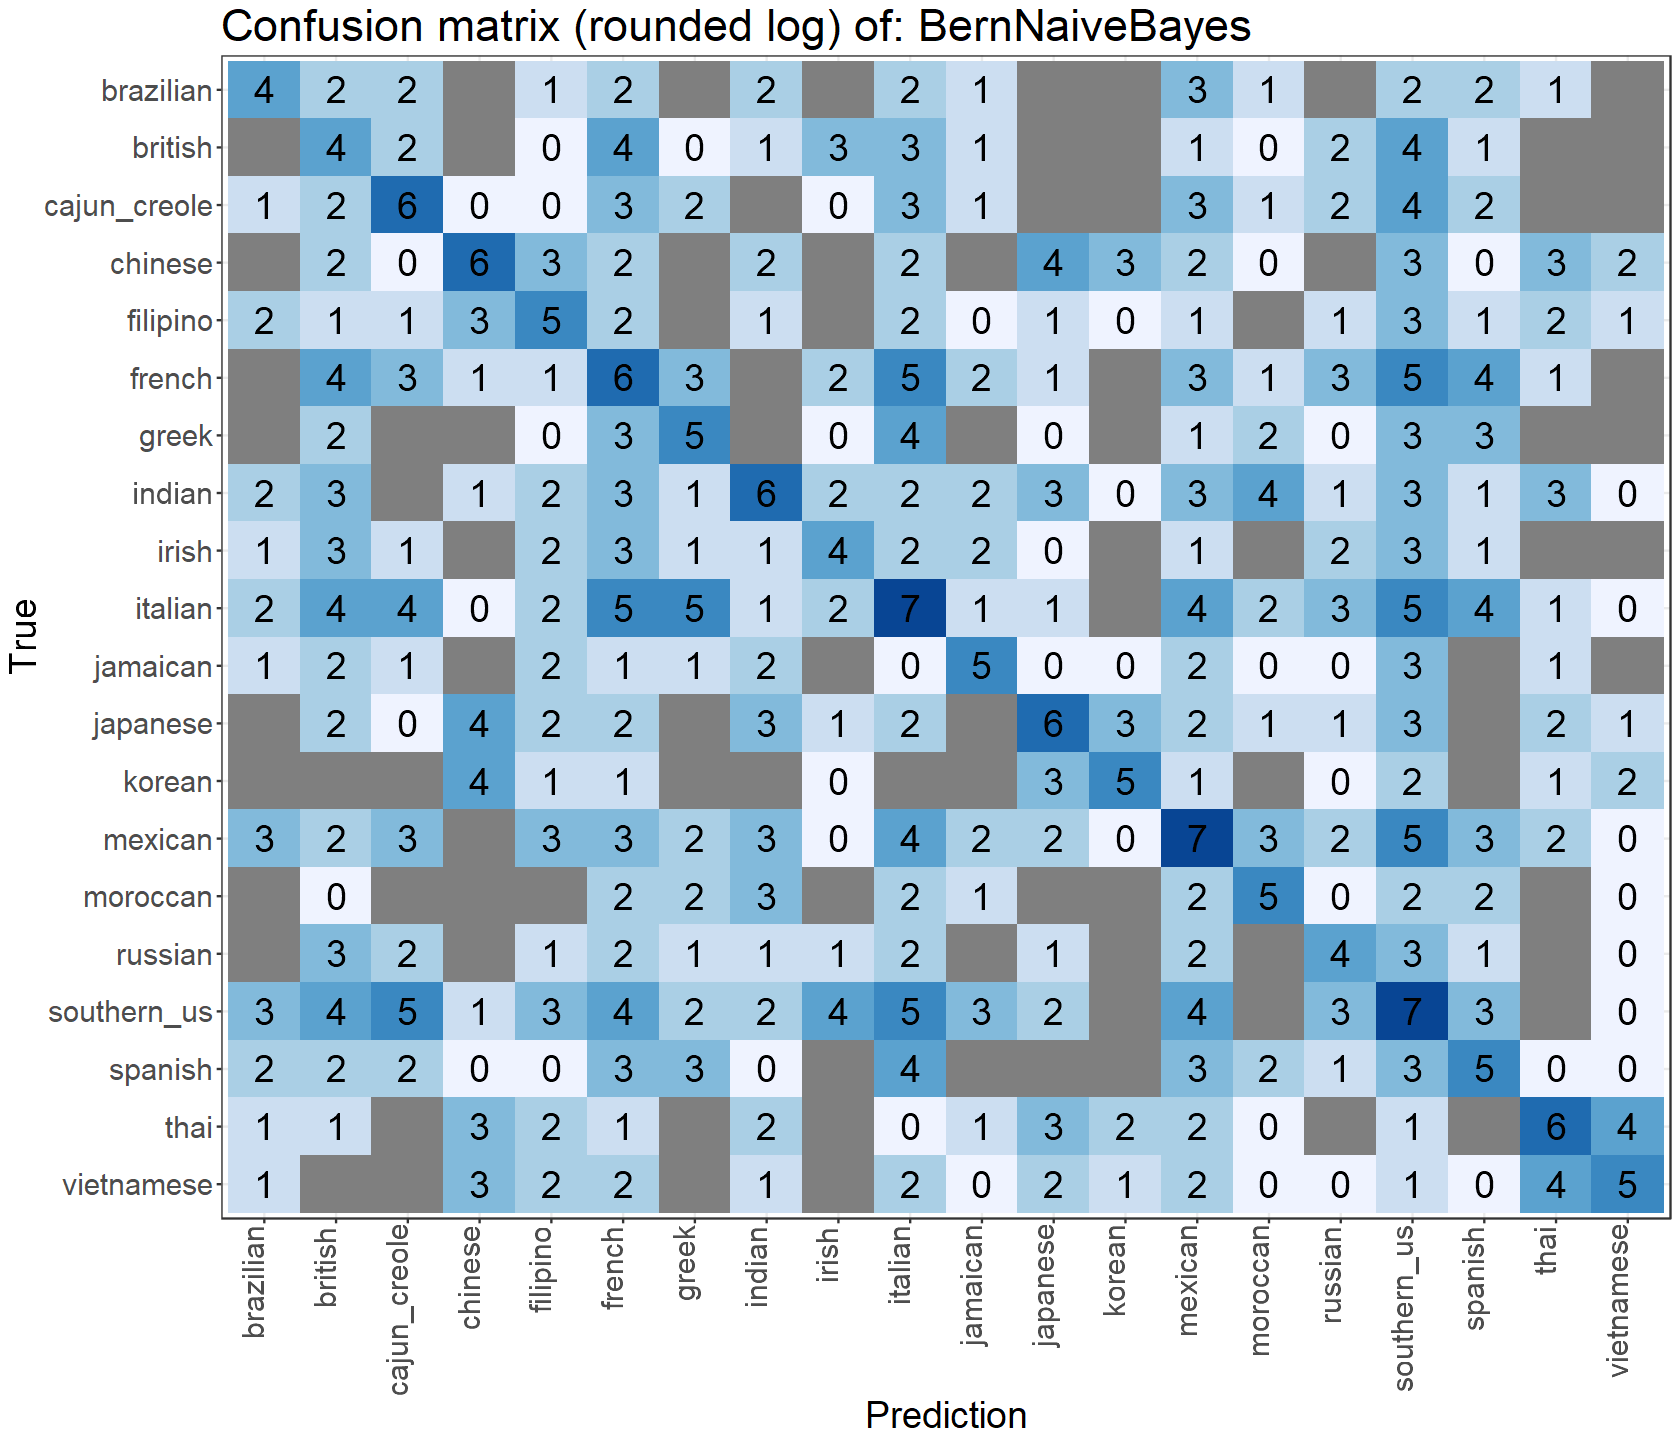

In [68]:
f_eval("BernNaiveBayes")



Model = BinLog_OneVsAll
overall accuracy training data = 0.76
overall accuracy test data = 0.71
macro f1 training data = 0.71
macro f1 test data = 0.64

Cuisine specific f1 scores
     Class: mexican       Class: indian      Class: chinese      Class: italian 
               0.86                0.85                0.78                0.76 
        Class: thai     Class: moroccan Class: cajun_creole     Class: jamaican 
               0.72                0.72                0.70                0.69 
      Class: korean        Class: greek     Class: japanese  Class: southern_us 
               0.69                0.67                0.67                0.64 
    Class: filipino    Class: brazilian       Class: french   Class: vietnamese 
               0.61                0.59                0.53                0.53 
     Class: spanish        Class: irish      Class: russian      Class: british 
               0.48                0.47                0.44                0.33 


Warning message:
"Removed 85 rows containing missing values (geom_text)."


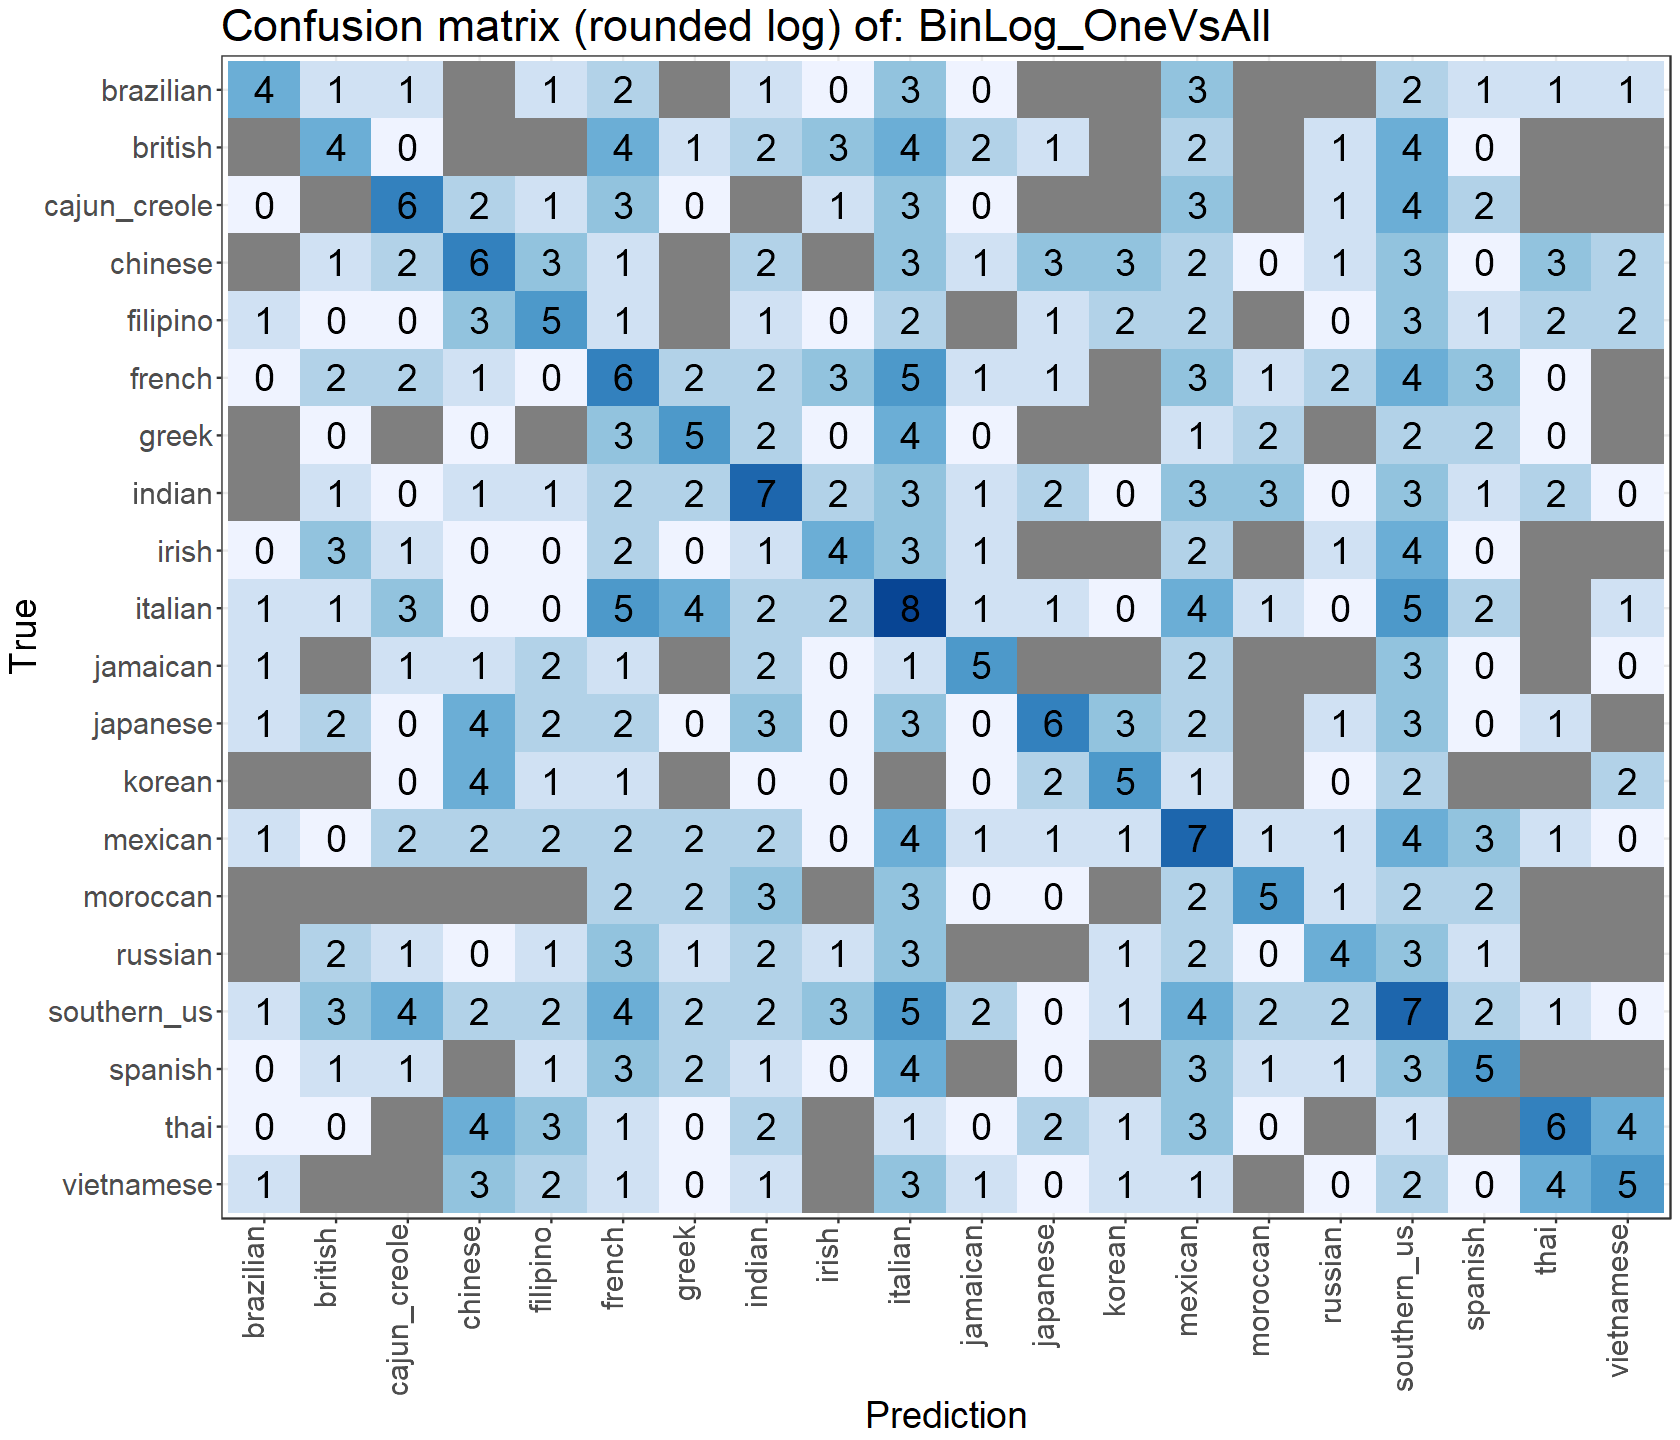

In [70]:
f_eval("BinLog_OneVsAll")



Model = kNN_k5
overall accuracy training data = 0.61
overall accuracy test data = 0.48
macro f1 training data = 0.52
macro f1 test data = 0.36

Cuisine specific f1 scores
     Class: italian       Class: indian      Class: mexican      Class: chinese 
               0.60                0.60                0.60                0.59 
    Class: japanese  Class: southern_us         Class: thai     Class: filipino 
               0.49                0.42                0.39                0.38 
   Class: brazilian       Class: korean        Class: greek   Class: vietnamese 
               0.37                0.35                0.32                0.31 
Class: cajun_creole     Class: jamaican       Class: french     Class: moroccan 
               0.31                0.30                0.30                0.24 
       Class: irish      Class: spanish      Class: british      Class: russian 
               0.21                0.16                0.12                0.04 


Warning message:
"Removed 85 rows containing missing values (geom_text)."


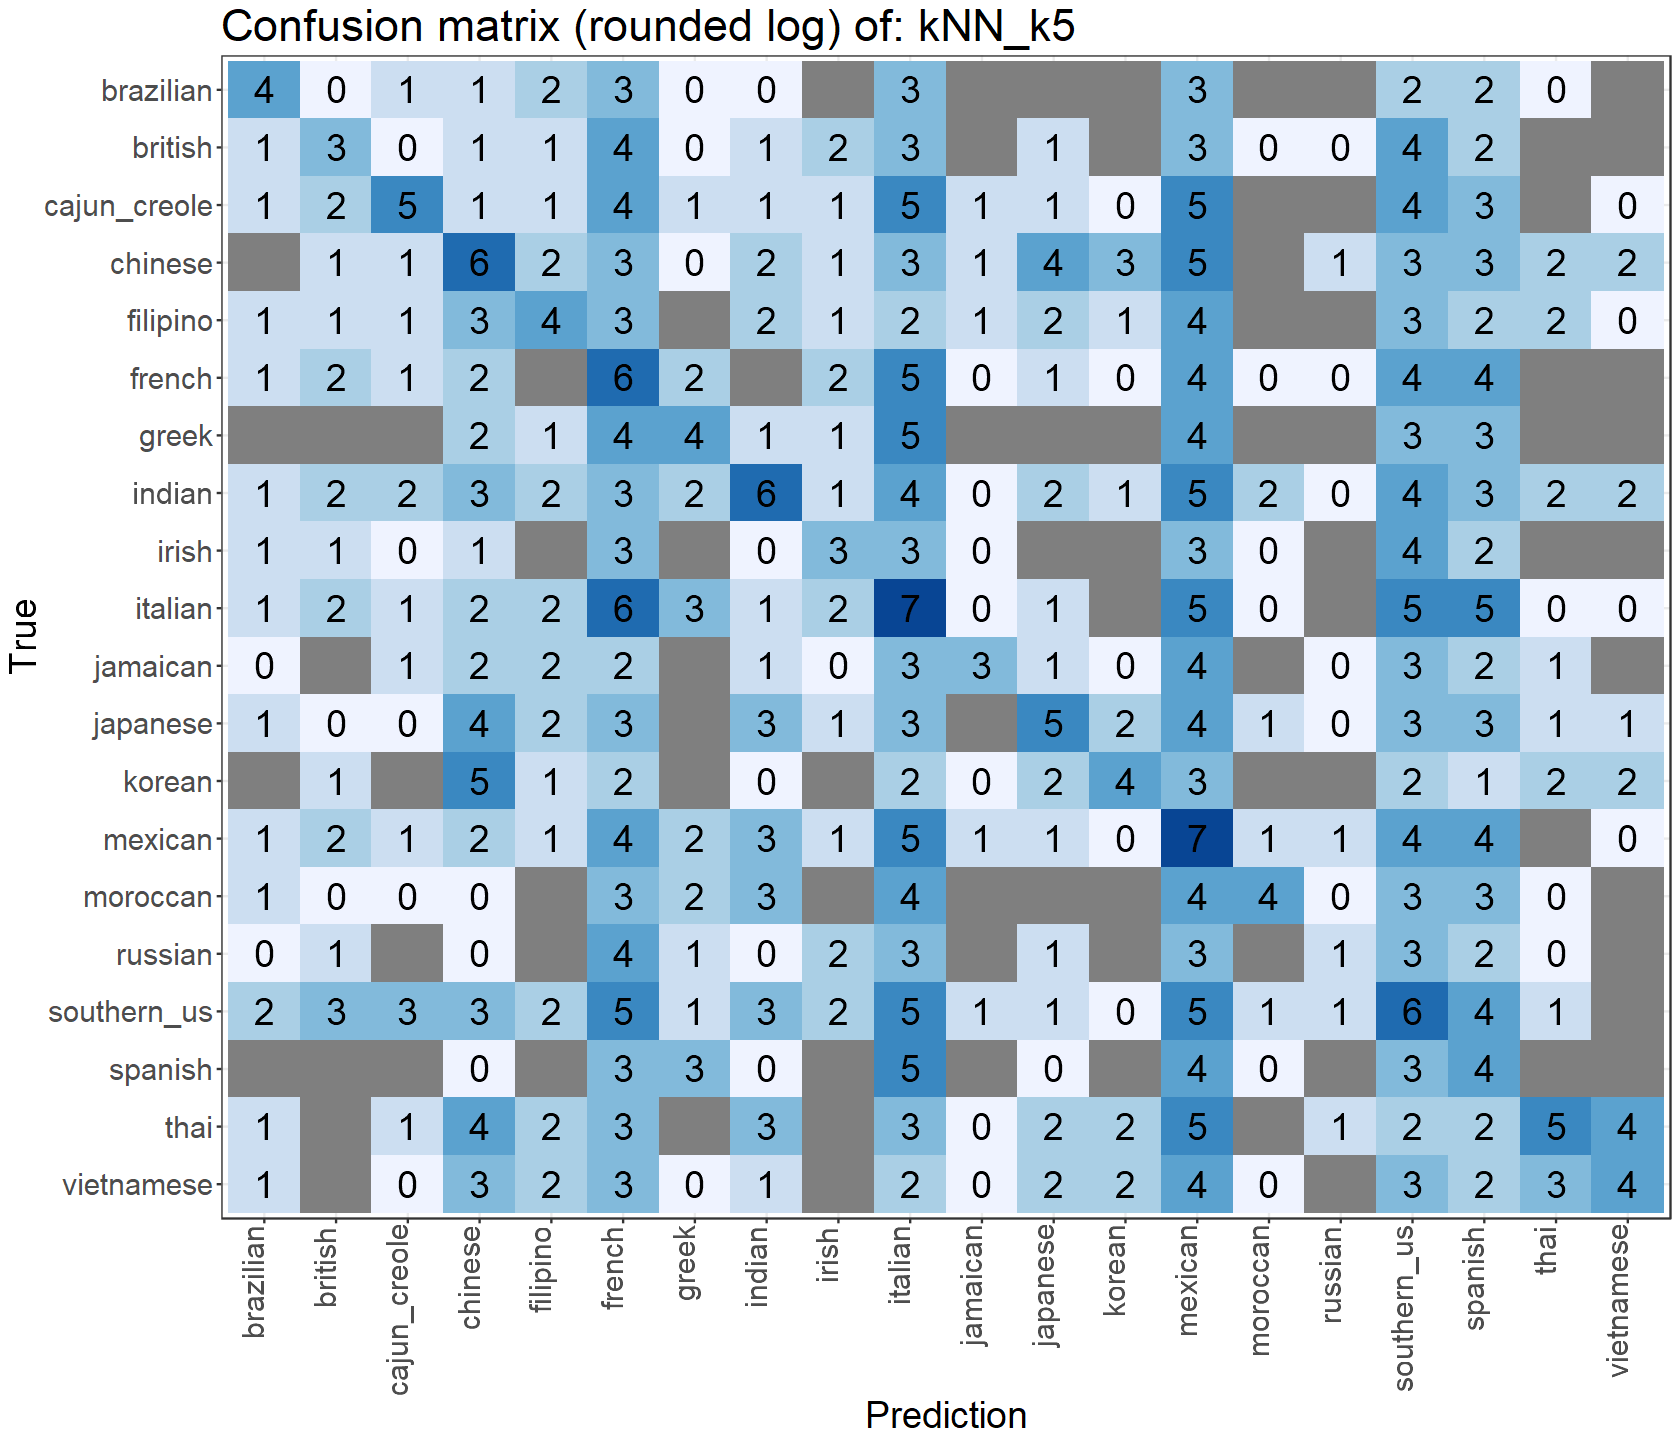

In [71]:
f_eval("kNN_k5")



Model = RForest
overall accuracy training data = 0.88
overall accuracy test data = 0.66
macro f1 training data = 0.87
macro f1 test data = 0.53

Cuisine specific f1 scores
     Class: mexican       Class: indian      Class: chinese      Class: italian 
               0.81                0.81                0.73                0.73 
Class: cajun_creole         Class: thai     Class: japanese        Class: greek 
               0.68                0.66                0.61                0.61 
    Class: moroccan  Class: southern_us       Class: korean     Class: filipino 
               0.58                0.58                0.58                0.51 
    Class: jamaican    Class: brazilian       Class: french   Class: vietnamese 
               0.47                0.47                0.42                0.41 
     Class: spanish        Class: irish      Class: russian      Class: british 
               0.35                0.26                0.23                0.15 


Warning message:
"Removed 119 rows containing missing values (geom_text)."


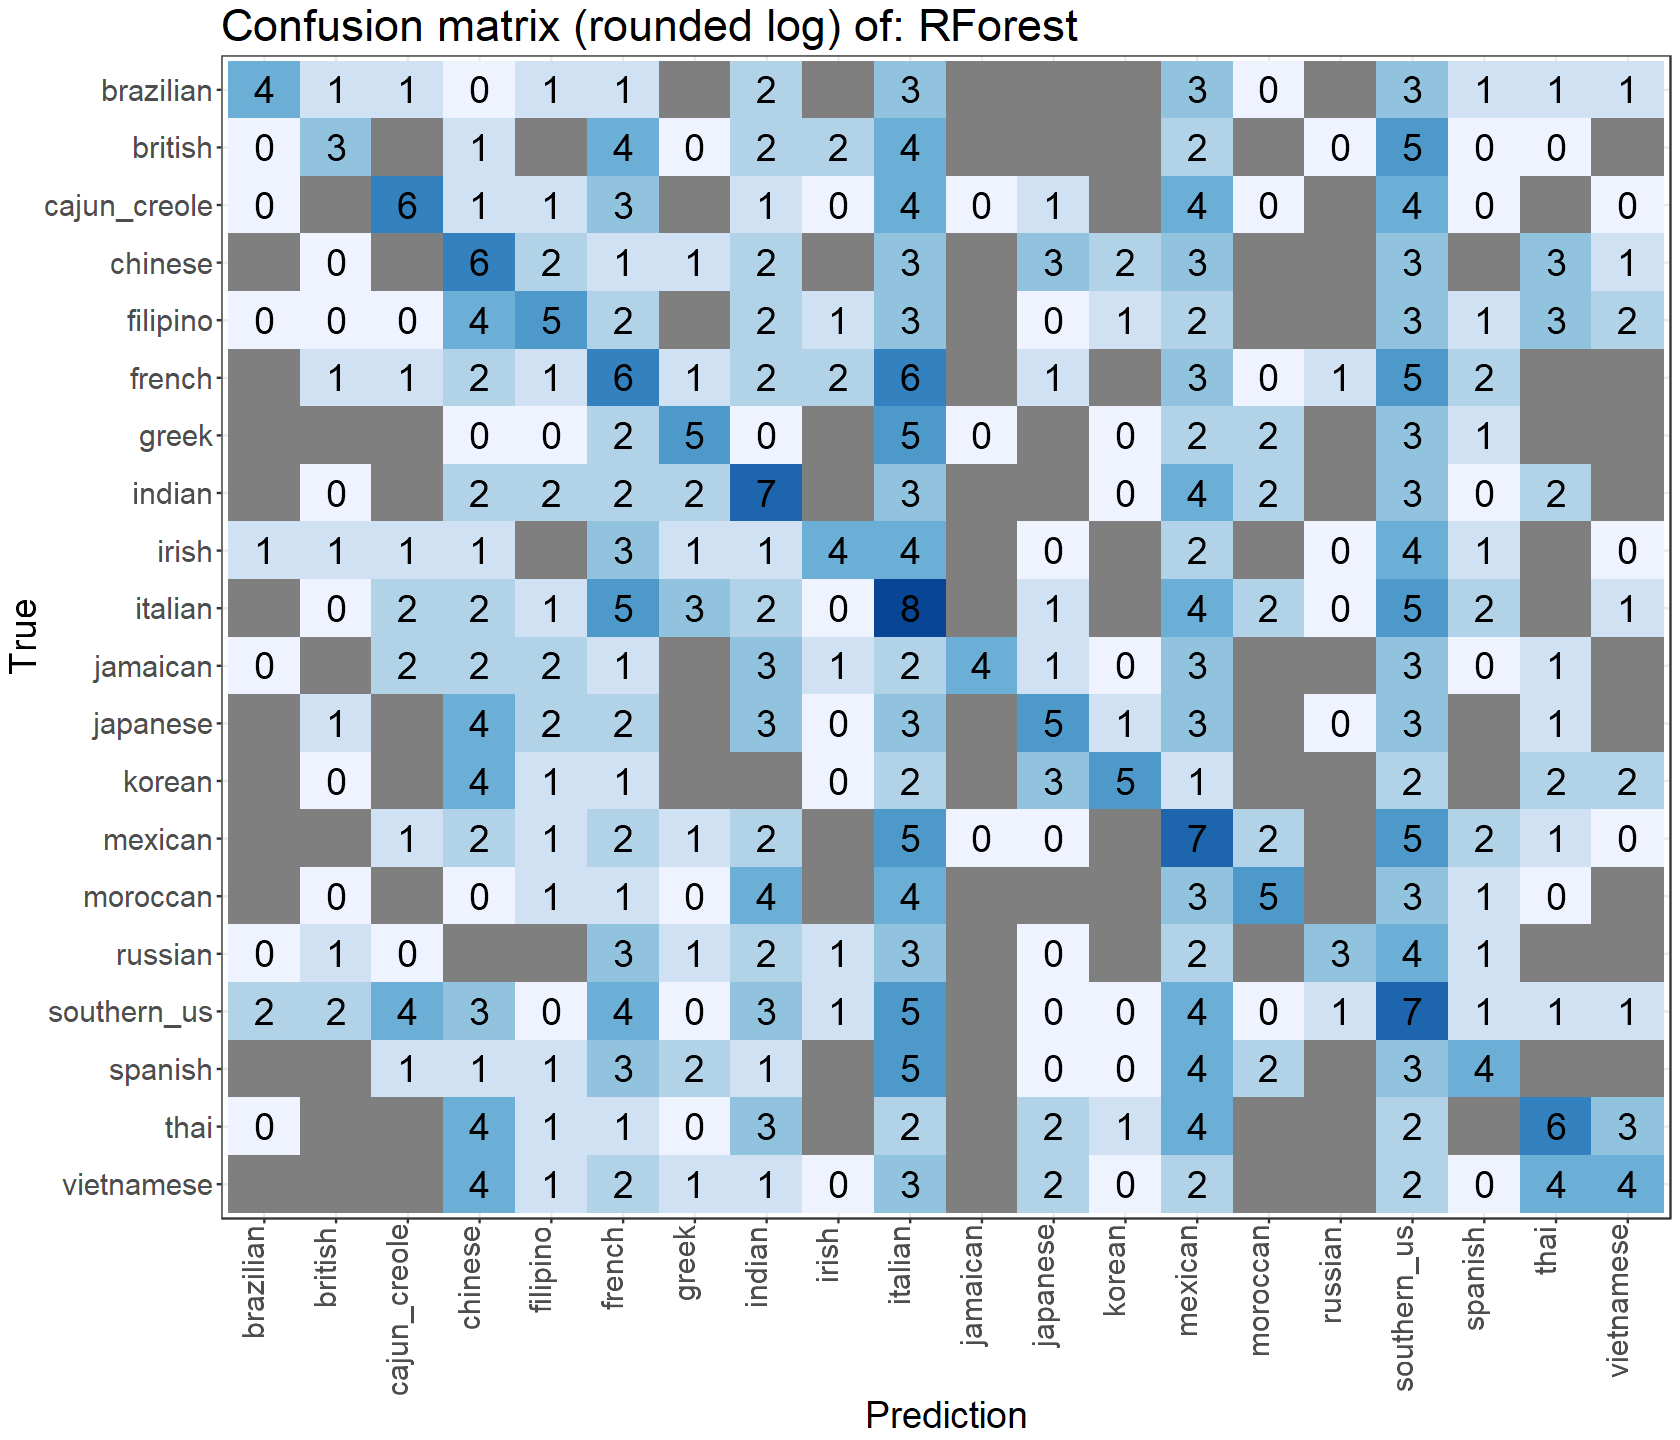

In [72]:
f_eval("RForest")



Model = XGBoost
overall accuracy training data = 0.87
overall accuracy test data = 0.71
macro f1 training data = 0.84
macro f1 test data = 0.62

Cuisine specific f1 scores
     Class: mexican       Class: indian      Class: chinese      Class: italian 
               0.85                0.84                0.78                0.76 
        Class: thai Class: cajun_creole     Class: japanese     Class: moroccan 
               0.72                0.70                0.69                0.67 
       Class: greek       Class: korean  Class: southern_us     Class: jamaican 
               0.67                0.67                0.64                0.61 
   Class: brazilian     Class: filipino   Class: vietnamese       Class: french 
               0.59                0.56                0.49                0.49 
       Class: irish      Class: spanish      Class: russian      Class: british 
               0.46                0.44                0.39                0.31 


Warning message:
"Removed 87 rows containing missing values (geom_text)."


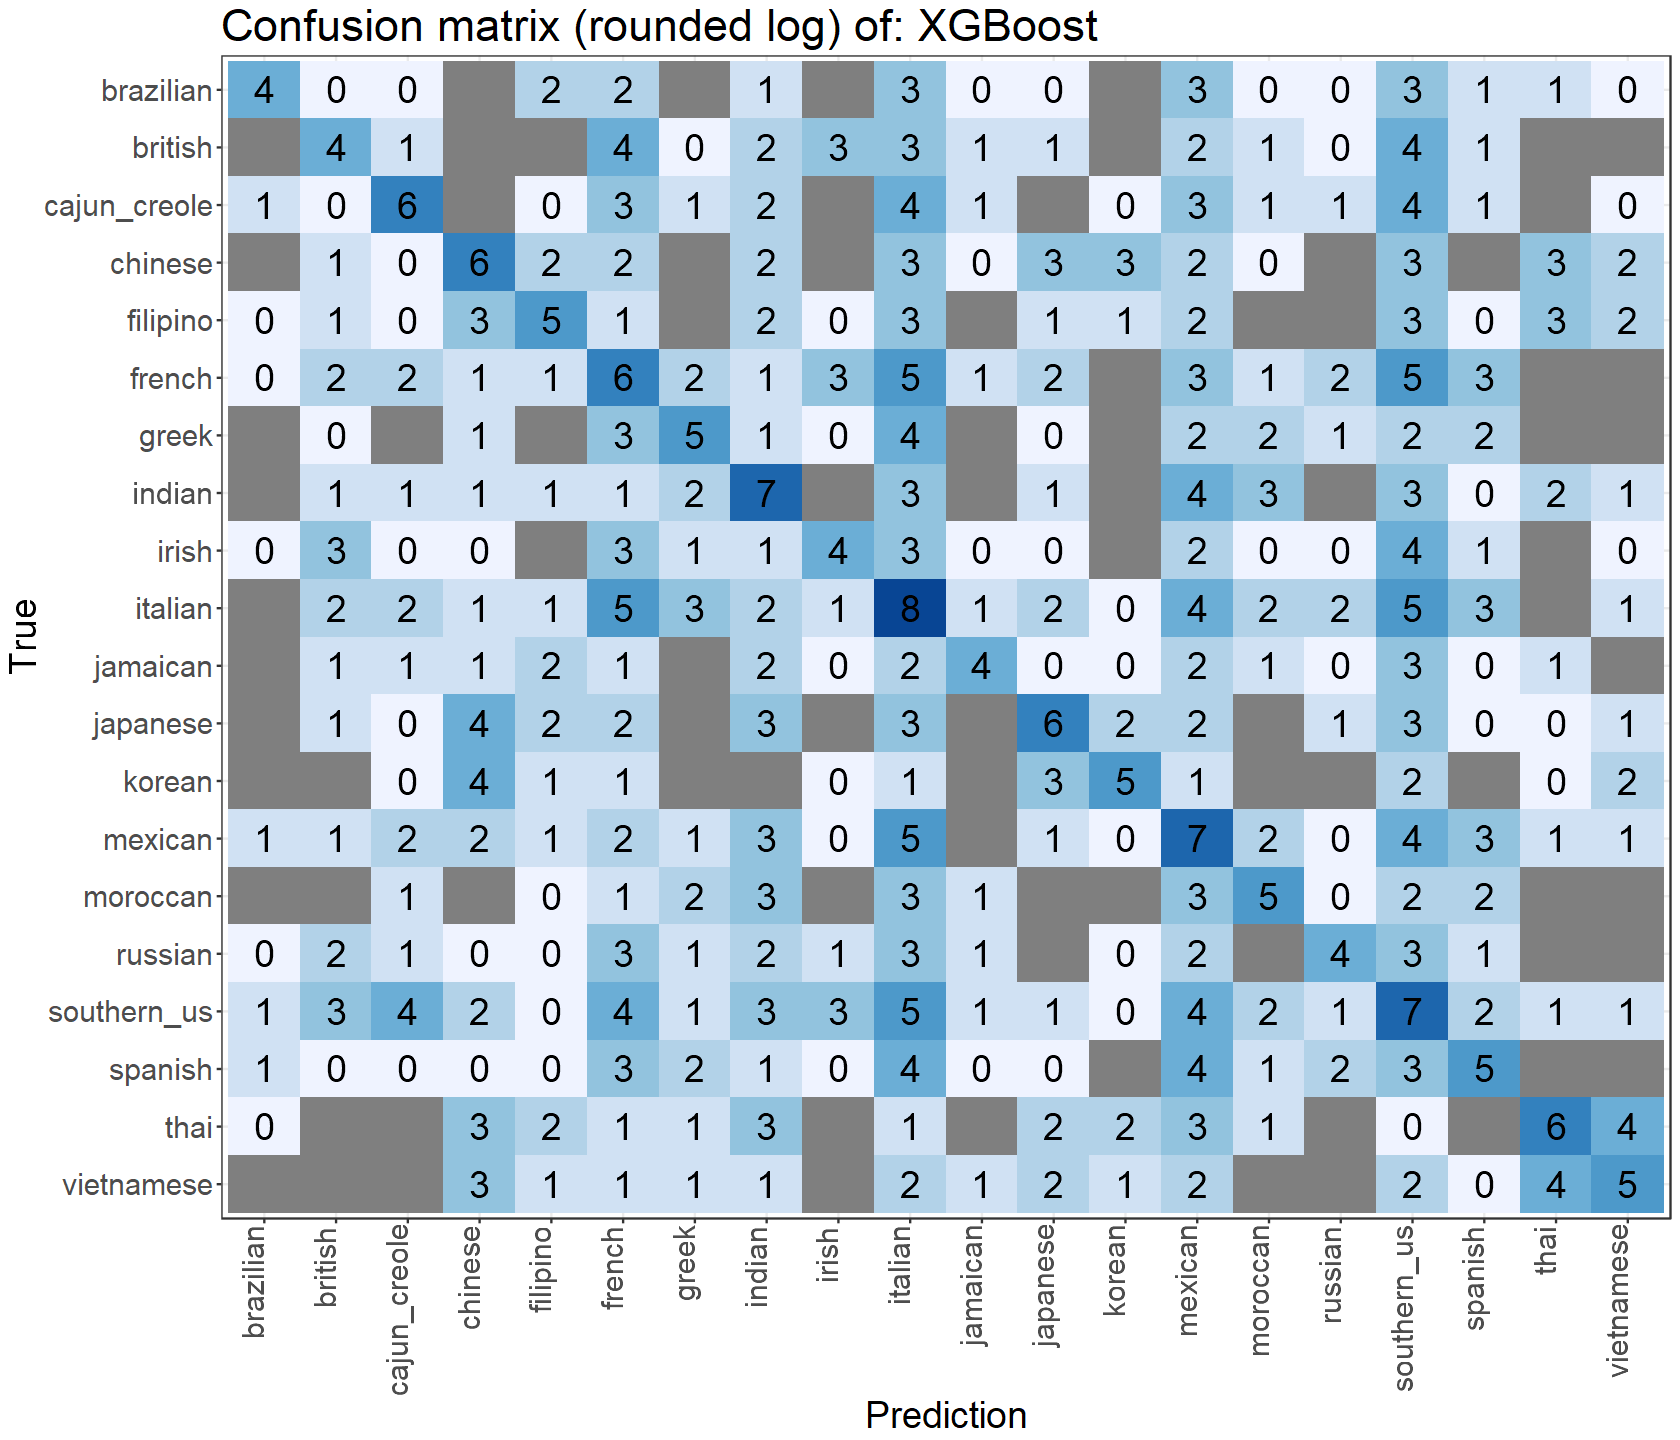

In [73]:
f_eval("XGBoost")